In [122]:
pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


Key Metrics to Focus On:

**1.	Accuracy:** Measures overall correctness of the model.

	•	Formula:
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$
	•	Useful if both classes (injury & non-injury) are balanced.
	•	Not reliable if class imbalance exists (e.g., if most reports are non-injury).
 
**2.	Precision (Positive Predictive Value - PPV):** Measures how many predicted injuries are actually injuries.
   
	•	Formula:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$
	•	Important if false positives (misclassifying non-injuries as injuries) cause unnecessary concern or cost.
	•	If precision is too high, recall might be low (you might miss real injuries).

**3.	Recall (Sensitivity, True Positive Rate - TPR):** Measures how many actual injuries were correctly identified.
	
	•	Formula:
$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
	•	Critical if missing an actual injury report is dangerous (e.g., safety audits, regulatory compliance).
	•	If recall is too high, precision might drop (you might get too many false positives).

**4.	F1-Score:** Harmonic mean of precision and recall.
	
 •	Formula:
$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
	•	Best for imbalanced datasets where both false positives and false negatives are important.




for the scenario **Missing an actual injury case is very bad (e.g., safety compliance, legal risk)**, we should focus on **High Recall (Minimize false negatives)**

In [23]:
import pandas as pd
import re
import string
import time
import numpy as np
# from langdetect import detect
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier



In [3]:
# Load the dataset
file_path = "safety_incident_reports.xlsx"
df = pd.read_excel(file_path)

df

,Description,label
0,A power surge disrupted airport check-in syste...,0
1,Een stewardess liep een blauwe plek op aan haa...,1
2,Een stewardess verstuikte haar enkel tijdens e...,1
3,A ramp crew member suffered lacerations from h...,1
4,Een beveiligingsmedewerker werd gebeten door e...,1
...,...,...
512,A passenger experienced dizziness and nausea ...,1
513,A cleaner slipped on a wet cabin floor and hur...,1
514,A ground crew vehicle collided with a parked a...,0
515,Een passagier liep een whiplash op door onverw...,1


In [5]:
from deep_translator import GoogleTranslator
import pandas as pd


# Function to translate text automatically to English
def translate_to_english(text):
    try:
        text = str(text).strip()
        translated_text = GoogleTranslator(source='auto', target='en').translate(text)
        return translated_text
    except Exception:
        return text  # If translation fails, return the original text
# Measure execution time
start_time = time.time()
# Apply direct translation
df['Translated_Description'] = df['Description'].apply(translate_to_english)
# Measure execution time
end_time = time.time()
# Save the updated dataset

# Display first few rows
print(df.head())

                                         Description  label  \
0  A power surge disrupted airport check-in syste...      0   
1  Een stewardess liep een blauwe plek op aan haa...      1   
2  Een stewardess verstuikte haar enkel tijdens e...      1   
3  A ramp crew member suffered lacerations from h...      1   
4  Een beveiligingsmedewerker werd gebeten door e...      1   

                              Translated_Description  
0  A power surge disrupted airport check-in syste...  
1  A flight attendant suffered a bruise to her ar...  
2  A flight attendant sprained her ankle during a...  
3  A ramp crew member suffered lacerations from h...  
4  A security guard was bitten by an assistance d...  


In [6]:
execution_time = end_time - start_time
print(f"Translation completed in {execution_time:.2f} seconds")


Translation completed in 99.00 seconds


In [5]:
# import time

# # Function to detect language
# def detect_language(text):
#     try:
#         text = str(text).strip()
#         return detect(text)
#     except:
#         return "unknown"

# # Apply language detection
# df['lang'] = df['Description'].apply(detect_language)

# # Function to translate non-English text to English
# def translate_to_english(text, lang):
#     if lang != 'en':
#         try:
#             return GoogleTranslator(source=lang, target='en').translate(text)
#         except:
#             return text  # If translation fails, return original text
#     return text

# # Apply translation

# df['Translated_Description'] = df.apply(lambda row: translate_to_english(row['Description'], row['lang']), axis=1)
# df

In [6]:
# from deep_translator import GoogleTranslator
# import pandas as pd

# # Function to detect language using Google Translator workaround
# def detect_language_google(text):
#     try:
#         text = str(text).strip()
#         translated_text = GoogleTranslator(source='auto', target='en').translate(text)  # Auto-detect language
#         if translated_text and translated_text.lower() != text.lower():  # If translation changed text
#             return "non-en"
#         else:
#             return "en"
#     except Exception:
#         return "unknown"  # If detection fails, return 'unknown'

# # Apply Google Translator's workaround for language detection
# %%time
# df['lang_google'] = df['Description'].apply(detect_language_google)

# # Function to translate non-English text to English
# def translate_to_english(text, lang):
#     if lang == "non-en":  # Only translate detected non-English text
#         try:
#             return GoogleTranslator(source='auto', target='en').translate(text)
#         except Exception:
#             return text  # If translation fails, keep original text
#     return text

# # Apply translation
# %%time
# df['Translated_Description_google'] = df.apply(lambda row: translate_to_english(row['Description'], row['lang_google']), axis=1)


In [11]:
# Save filtered dataset
df.to_excel("df_cleaned.xlsx", index=False)

In [9]:
# from deep_translator import GoogleTranslator
# from langdetect import detect

# def translate_to_english(text):
#     """Detect language and translate if Dutch."""
#     try:
#         lang = detect(text)  # Detect language
#         if lang == 'nl':  # If Dutch, translate to English
#             return GoogleTranslator(source='nl', target='en').translate(text)
#         return text  # If already English, return as is
#     except:
#         return text  # In case of errors, return original text

# # Apply translation to the 'Description' column
# df['Translated_Description'] = df['Cleaned_Description'].astype(str).apply(translate_to_english)

# # Display some translated samples
# df[['Description', 'Translated_Description']].head()

In [10]:
# from nltk.tokenize import word_tokenize

# # Test if tokenization works
# sample_text = "This is a test sentence."
# tokens = word_tokenize(sample_text)
# print("Tokenization successful:", tokens)

Tokenization successful: ['This', 'is', 'a', 'test', 'sentence', '.']


In [9]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /Users/mustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mustafa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
def clean_text(text):
    """Cleans and preprocesses text."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)  # Convert tokens back to string

df['Cleaned_Description'] = df['Translated_Description'].astype(str).apply(clean_text)
df

,Description,label,Translated_Description,Cleaned_Description
0,A power surge disrupted airport check-in syste...,0,A power surge disrupted airport check-in syste...,power surge disrupted airport checkin system d...
1,Een stewardess liep een blauwe plek op aan haa...,1,A flight attendant suffered a bruise to her ar...,flight attendant suffered bruise arm malfuncti...
2,Een stewardess verstuikte haar enkel tijdens e...,1,A flight attendant sprained her ankle during a...,flight attendant sprained ankle safety demonst...
3,A ramp crew member suffered lacerations from h...,1,A ramp crew member suffered lacerations from h...,ramp crew member suffered laceration handling ...
4,Een beveiligingsmedewerker werd gebeten door e...,1,A security guard was bitten by an assistance d...,security guard bitten assistance dog became re...
...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,A passenger experienced dizziness and nausea a...,passenger experienced dizziness nausea prolong...
513,A cleaner slipped on a wet cabin floor and hur...,1,A cleaner slipped on a wet cabin floor and hur...,cleaner slipped wet cabin floor hurt back tidy...
514,A ground crew vehicle collided with a parked a...,0,A ground crew vehicle collided with a parked a...,ground crew vehicle collided parked airplane c...
515,Een passagier liep een whiplash op door onverw...,1,A passenger suffered whiplash due to unexpecte...,passenger suffered whiplash due unexpected sev...


In [17]:
# import nltk
# from nltk.corpus import stopwords

# # Download required resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Ensure stopwords are downloaded
# try:
#     stop_words = set(stopwords.words('english'))
# except LookupError:
#     nltk.download('stopwords')
#     stop_words = set(stopwords.words('english'))

# # Initialize other tool

[nltk_data] Downloading package punkt to /Users/mustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mustafa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
df

,Description,label,Translated_Description,Cleaned_Description
0,A power surge disrupted airport check-in syste...,0,A power surge disrupted airport check-in syste...,power surge disrupted airport checkin system d...
1,Een stewardess liep een blauwe plek op aan haa...,1,A flight attendant suffered a bruise to her ar...,flight attendant suffered bruise arm malfuncti...
2,Een stewardess verstuikte haar enkel tijdens e...,1,A flight attendant sprained her ankle during a...,flight attendant sprained ankle safety demonst...
3,A ramp crew member suffered lacerations from h...,1,A ramp crew member suffered lacerations from h...,ramp crew member suffered laceration handling ...
4,Een beveiligingsmedewerker werd gebeten door e...,1,A security guard was bitten by an assistance d...,security guard bitten assistance dog became re...
...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,A passenger experienced dizziness and nausea a...,passenger experienced dizziness nausea prolong...
513,A cleaner slipped on a wet cabin floor and hur...,1,A cleaner slipped on a wet cabin floor and hur...,cleaner slipped wet cabin floor hurt back tidy...
514,A ground crew vehicle collided with a parked a...,0,A ground crew vehicle collided with a parked a...,ground crew vehicle collided parked airplane c...
515,Een passagier liep een whiplash op door onverw...,1,A passenger suffered whiplash due to unexpecte...,passenger suffered whiplash due unexpected sev...


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Display basic info
print("Dataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Description             517 non-null    object
 1   label                   517 non-null    int64 
 2   Translated_Description  517 non-null    object
 3   Cleaned_Description     517 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.3+ KB

Missing Values:
 Description               0
label                     0
Translated_Description    0
Cleaned_Description       0
dtype: int64


No Missing Values: Dataset is complete.

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_98123/32936681.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['label'], palette='coolwarm')


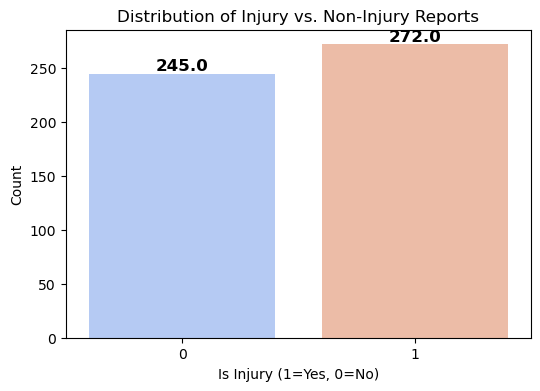

In [23]:
# Label distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x=df['label'], palette='coolwarm')
plt.title("Distribution of Injury vs. Non-Injury Reports")
plt.xlabel("Is Injury (1=Yes, 0=No)")
plt.ylabel("Count")

# Add text labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.show()


Balanced Dataset: No major class imbalance, meaning no need for oversampling or undersampling.

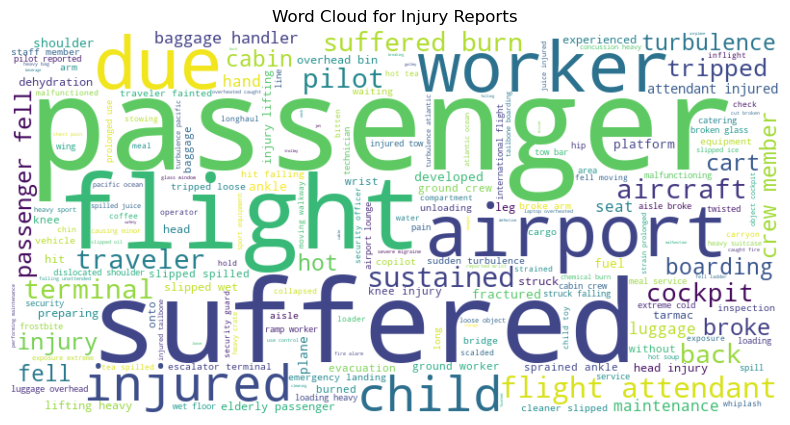

In [25]:

# Wordcloud for injury-related reports
injury_text = " ".join(df[df['label'] == 1]['Cleaned_Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(injury_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Injury Reports")
plt.show()


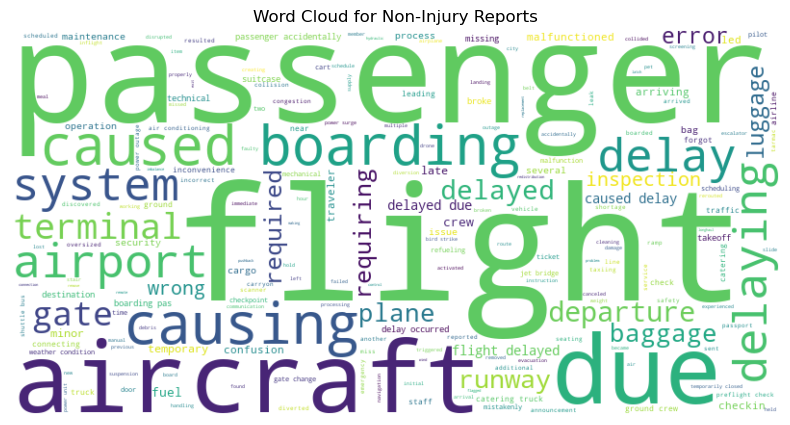

In [27]:

# Wordcloud for non-injury reports
non_injury_text = " ".join(df[df['label'] == 0]['Cleaned_Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_injury_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Non-Injury Reports")
plt.show()


- Injury Reports: Common words include “suffered”, “passenger”, “injured”, “worker”, “fell”, “burn”, “turbulence”.
- Non-Injury Reports: Common words include “passenger”, “aircraft”, “delayed”, “boarding”, “gate”, “caused”, “system”.
- Observation: Injury-related reports emphasize physical harm (e.g., burns, fractures), while non-injury reports are about operational issues (e.g., delays, system failures).

In [29]:

# Most common words in injury reports
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
all_words = " ".join(df[df['label'] == 1]['Cleaned_Description'].astype(str)).split()
filtered_words = [word for word in all_words if word not in stop_words and word not in string.punctuation]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_98123/914761710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='coolwarm')


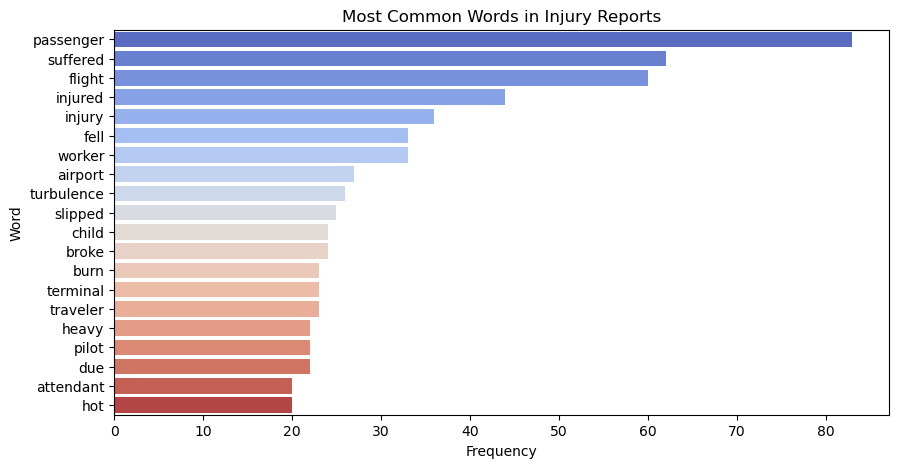

In [31]:

# Plot most common words
plt.figure(figsize=(10, 5))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most Common Words in Injury Reports")
plt.show()


- Top Words: "passenger", "suffered", "flight", "injured", "injury", "fell", "worker", "burn".-
- Analysis: Injury-related reports are often about passengers and workers suffering injuries.
- Next Step: Consider creating custom features based on keywords (e.g., a binary feature for whether words like suffered or burn appear in the report).

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_98123/1652136493.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['label'], y=df['word_count'], palette='coolwarm')


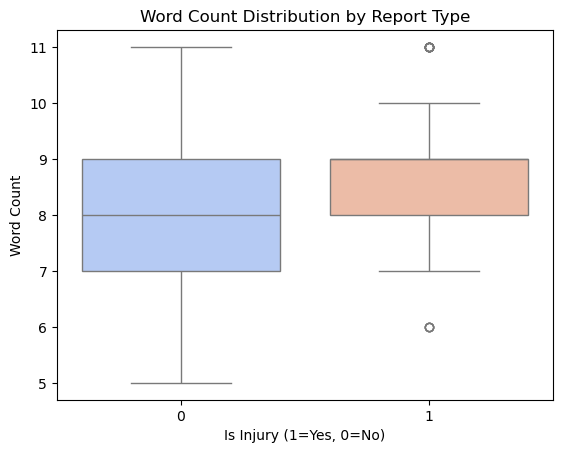

In [33]:

# Average word count per report
df['word_count'] = df['Cleaned_Description'].apply(lambda x: len(str(x).split()))
sns.boxplot(x=df['label'], y=df['word_count'], palette='coolwarm')
plt.xlabel("Is Injury (1=Yes, 0=No)")
plt.ylabel("Word Count")
plt.title("Word Count Distribution by Report Type")
plt.show()


- Median Word Count: ~8 words per report.
- Range: 5 to 11 words.
- Analysis: Injury and non-injury reports have similar word count distributions. This suggests that word count alone is not a strong predictive feature.

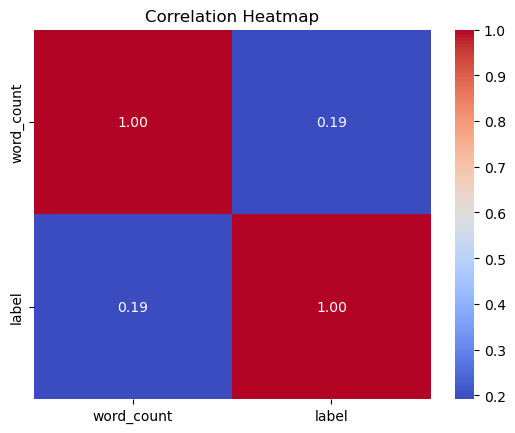

In [35]:

# Display correlation between word count and label
correlation = df[['word_count', 'label']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


- Weak correlation (0.19) between word_count and label.
- Interpretation: The number of words in a report is not strongly associated with whether it describes an injury.

## Next Steps

- Perform N-Gram Analysis to detect common bigrams/trigrams.
  
  Single-word analysis is useful, but phrase patterns (e.g., “hot coffee spill”, “fell off ladder”) may be stronger indicators of injuries.
  
- Run Named Entity Recognition (NER) to extract entities related to injuries.
  
  Identify specific entities (e.g., body parts, injury types) to enhance classification.
  
- Conduct Sentiment Analysis to see if injury reports have stronger negativity.
  
  Injury reports may have more negative sentiment compared to non-injury reports.
  
- Extract Feature Importance from TF-IDF to find the strongest predictors.
  
  Identify the most informative words in distinguishing injury vs. non-injury reports.

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_99839/2614614998.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')


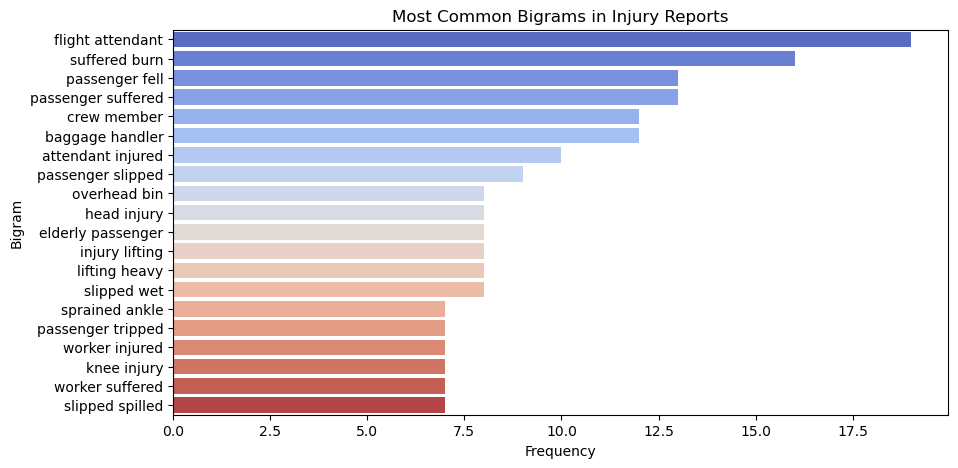

In [79]:
from nltk.util import ngrams

# Function to extract n-grams
def get_ngrams(texts, n=2, top_n=20):
    all_ngrams = []
    for text in texts:
        words = [word for word in text.split() if word not in stop_words]
        all_ngrams.extend(list(ngrams(words, n)))
    
    ngram_counts = Counter(all_ngrams).most_common(top_n)
    return ngram_counts

# Extract and plot bigrams for injury reports
bigrams = get_ngrams(df[df['label'] == 1]['Cleaned_Description'], n=2)
bigram_labels, bigram_counts = zip(*bigrams)
bigram_labels = [" ".join(b) for b in bigram_labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.title("Most Common Bigrams in Injury Reports")
plt.show()


Frequent bigrams (word pairs) include "flight attendant", "suffered burn", "passenger fell", "crew member", "sprained ankle".

Insights:

- Many injuries involve passengers and crew members.

- Specific injuries include burns, falls, and sprains, suggesting injury types could be leveraged as features.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.8 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_99839/1939495524.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ner_frequencies, y=ner_labels, palette='coolwarm')


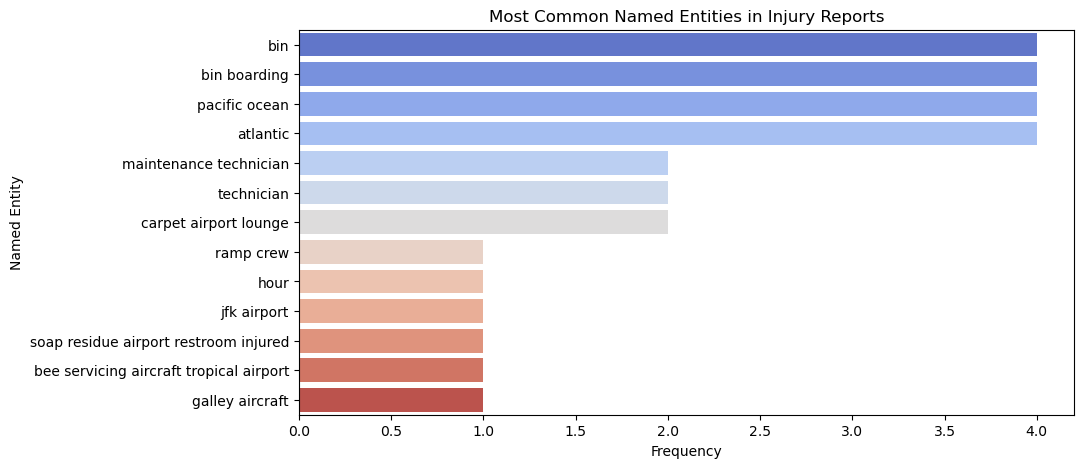

In [19]:
import spacy
spacy.cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")

# Named Entity Recognition (NER)
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.text for ent in doc.ents])
    return Counter(entities).most_common(20)

ner_counts = extract_named_entities(df[df['label'] == 1]['Cleaned_Description'])
ner_labels, ner_frequencies = zip(*ner_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=ner_frequencies, y=ner_labels, palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Named Entity")
plt.title("Most Common Named Entities in Injury Reports")
plt.show()


Most common named entities include "bin boarding", "maintenance technician", "ramp crew", "JFK airport".

Insights:

- Some injuries are location-based (e.g., airport areas, boarding zones).

- Specific job roles (e.g., technician, crew member) appear frequently, suggesting that employee roles might be relevant features.

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_98123/2665233450.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['label'], y=df['sentiment_score'], palette='coolwarm')


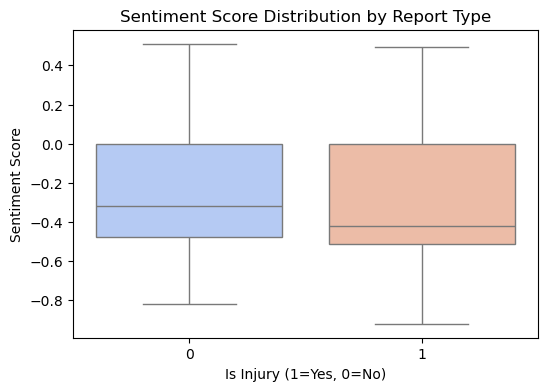

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Sentiment Analysis
df['sentiment_score'] = df['Cleaned_Description'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

plt.figure(figsize=(6, 4))
sns.boxplot(x=df['label'], y=df['sentiment_score'], palette='coolwarm')
plt.xlabel("Is Injury (1=Yes, 0=No)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score Distribution by Report Type")
plt.show()


Both injury and non-injury reports tend to have negative sentiment scores, meaning sentiment alone may not be a strong predictor.

Insights:

- Injury reports seem slightly more negative, but the overlap suggests we should not use sentiment as a sole classifier.

- Could explore specific sentiment words (e.g., "suffered", "burn", "fractured").

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_98123/2633455231.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=important_scores, y=important_features, palette='coolwarm')


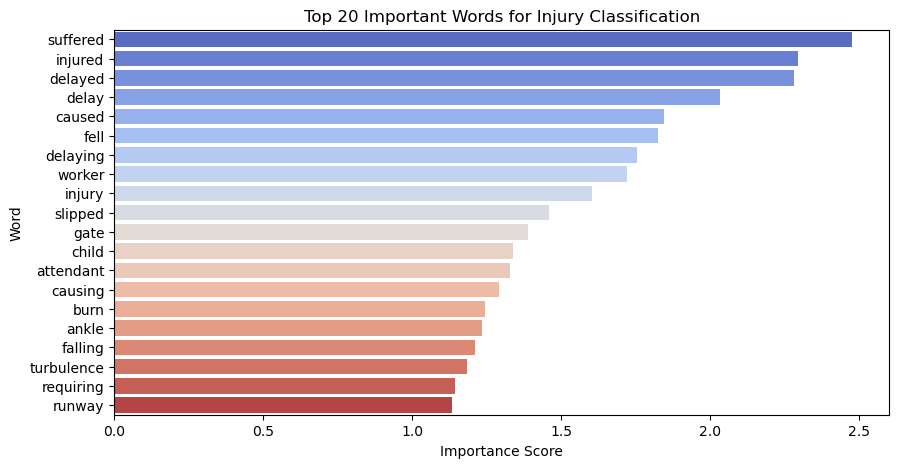

In [43]:
# TF-IDF Feature Importance
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X_tfidf, y)

# Extract feature importance
feature_names = np.array(vectorizer.get_feature_names_out())
feature_importance = np.abs(model.coef_).flatten()
important_features = feature_names[np.argsort(-feature_importance)[:20]]
important_scores = feature_importance[np.argsort(-feature_importance)[:20]]

# Plot important words
plt.figure(figsize=(10, 5))
sns.barplot(x=important_scores, y=important_features, palette='coolwarm')
plt.xlabel("Importance Score")
plt.ylabel("Word")
plt.title("Top 20 Important Words for Injury Classification")
plt.show()


Top predictive words: "suffered", "injured", "delayed", "delay", "caused", "fell", "delaying", "worker".

Insights:

- Words directly describing injuries (e.g., "suffered", "burn", "injury") are crucial features.

- Some non-injury words (e.g., "delayed") appear, suggesting that some reports might include both operational issues and injuries.

# V0 Models

In [46]:

# Split dataset into training, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(df['Cleaned_Description'], df['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Splitting temp data equally for validation and test

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)



Validation Results - Logistic Regression
Validation Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        46

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



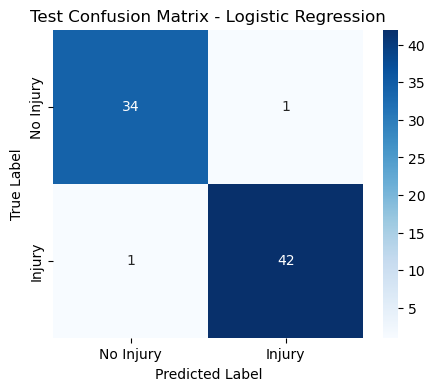

Validation Results - Random Forest
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



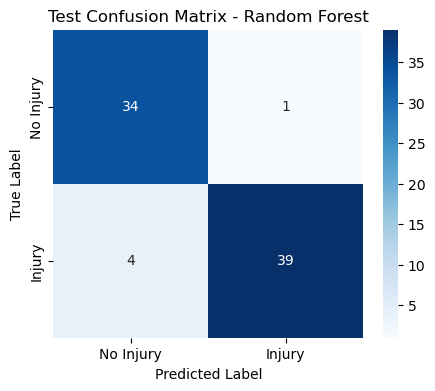

Validation Results - SVM
Validation Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        46

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78



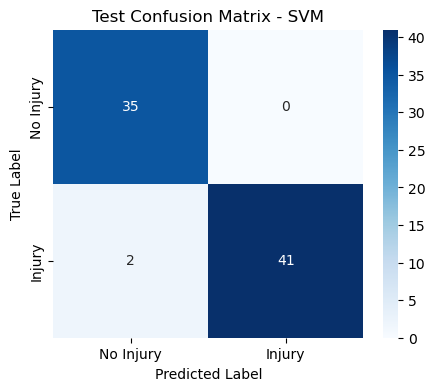

Final Test Results - Logistic Regression
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.98      0.98      0.98        43

    accuracy                           0.97        78
   macro avg       0.97      0.97      0.97        78
weighted avg       0.97      0.97      0.97        78

Final Test Results - Random Forest
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.97      0.91      0.94        43

    accuracy                           0.94        78
   macro avg       0.93      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78

Final Test Results - SVM
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.95      0.98        43

    accuracy   

In [48]:

# Model Training & Evaluation with Validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    # Train model on training set
    model.fit(X_train_tfidf, y_train)
    
    # Validate model on validation set
    y_val_pred = model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)
    
    # Test model on test set after validation
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_class_report = classification_report(y_test, y_test_pred)
    
    results[name] = {
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "Test Confusion Matrix": test_conf_matrix,
        "Test Classification Report": test_class_report
    }
    
    # Confusion Matrix Plot for Test Data
    plt.figure(figsize=(5, 4))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Test Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Test Classification Report"])
    print("=" * 60)

### Confusion Matrix Analysis

Each model was tested on 78 test samples with:

	•	35 non-injury cases (0)
	•	43 injury cases (1)

Observations

	•	SVM has perfect precision for non-injury cases (TN: 35, FP: 0) but misses 2 injury cases (FN: 2).
	•	Random Forest misclassifies 4 injury cases as non-injury (FN: 4), suggesting it struggles with injury cases.
	•	Logistic Regression is well-balanced, but it has 1 FP and 1 FN.

In [46]:
# Print Evaluation Results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Validation Accuracy']:.4f}")
    print("Classification Report:\n", metrics['Test Classification Report'])
    print("------------------------------------------------------------\n")


Model: Logistic Regression
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.98      0.98      0.98        43

    accuracy                           0.97        78
   macro avg       0.97      0.97      0.97        78
weighted avg       0.97      0.97      0.97        78

------------------------------------------------------------

Model: Random Forest
Accuracy: 0.9744
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.97      0.91      0.94        43

    accuracy                           0.94        78
   macro avg       0.93      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78

------------------------------------------------------------

Model: SVM
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-sc

### Summary of Results

    •	Validation accuracy is higher than test accuracy in all models, suggesting slight overfitting.
	•	Random Forest has the largest drop in accuracy from validation (97.44%) to test (93.59%).
	•	Logistic Regression and SVM both achieved 100% validation accuracy, indicating they might be memorizing the training data.

### Precision, Recall, and F1-Score

Observations

	•	SVM has the best precision for injury cases (1.00) but slightly lower recall (0.95).
	•	Random Forest has the worst recall for injury cases (0.91), meaning it misses more actual injury reports.
	•	Logistic Regression is the most balanced, slightly outperforming SVM on recall.

### Overfitting Analysis

	•	Both SVM and Logistic Regression have 100% validation accuracy but drop in test accuracy → This indicates possible overfitting.
	•	Random Forest’s drop in accuracy (97.44% → 93.59%) shows that it struggles to generalize compared to SVM and Logistic Regression.

### Recommendations

Next Steps to Reduce Overfitting

	1.	Use More Training Data
    	•   If possible, increase the dataset size to improve generalization.
    	•	Augment text data or add more diverse examples.
     
	2.	Tune Hyperparameters
    	•	Reduce C value in SVM to improve generalization:
        •	Reduce n_estimators in Random Forest to avoid overfitting.
        
	3.	Regularization
    	•	Use L2 regularization in Logistic Regression to reduce overfitting
     
    4.	Try Ensemble Methods
    	•	Combine Logistic Regression & SVM for a hybrid approach.
    	•	Use Voting Classifier to aggregate predictions from multiple models.


## New Model - V0

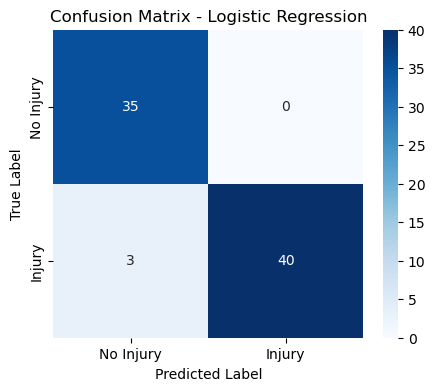

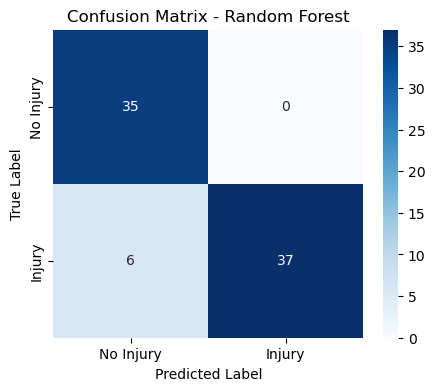

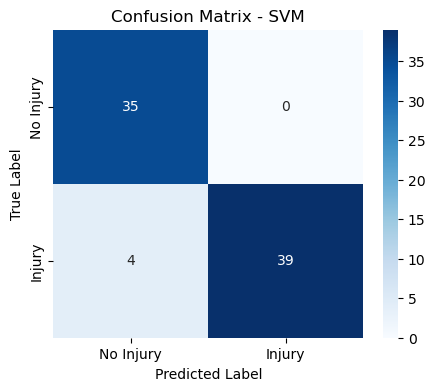

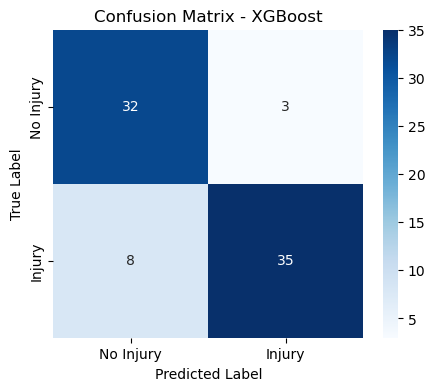

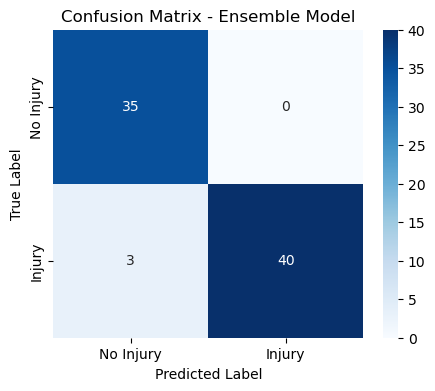

Final Test Results - Logistic Regression
Test Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.93      0.96        43

    accuracy                           0.96        78
   macro avg       0.96      0.97      0.96        78
weighted avg       0.96      0.96      0.96        78

Final Test Results - Random Forest
Test Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        35
           1       1.00      0.86      0.93        43

    accuracy                           0.92        78
   macro avg       0.93      0.93      0.92        78
weighted avg       0.93      0.92      0.92        78

Final Test Results - SVM
Test Accuracy: 0.9487
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        35
           1       1.00      0.91      0.95        43

    accuracy   

In [57]:

# Function to extract named entities
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.label_ for ent in doc.ents])
    return Counter(entities).most_common(20)

# Apply Named Entity Recognition (NER)
df['named_entities'] = df['Cleaned_Description'].apply(lambda x: extract_named_entities([x]))

# Convert text data to numerical features using TF-IDF with n-grams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hyperparameter tuning for models
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

rf_param_grid = {'n_estimators': [100, 300], 'max_depth': [10, 20], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# Advanced model: XGBoost
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Ensemble Learning using Voting Classifier
voting_clf = VotingClassifier(estimators=[('log_reg', best_log_reg), ('rf', best_rf), ('svm', best_svm), ('xgb', xgb_model)], voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": xgb_model,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

Validation Results - Logistic Regression
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



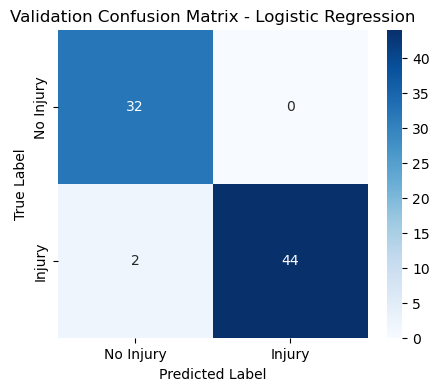

Validation Results - Random Forest
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        32
           1       1.00      0.80      0.89        46

    accuracy                           0.88        78
   macro avg       0.89      0.90      0.88        78
weighted avg       0.91      0.88      0.89        78



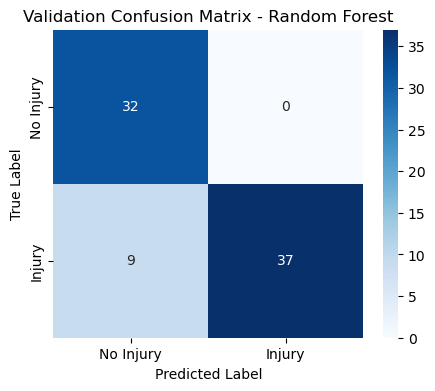

Validation Results - SVM
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



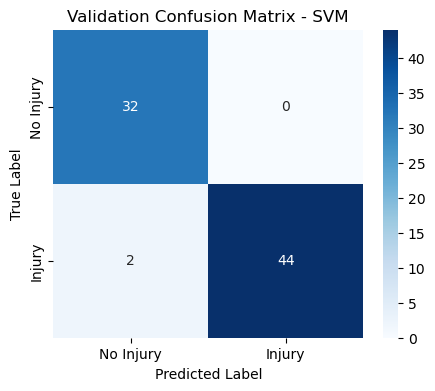

Validation Results - XGBoost
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.89      0.91      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.88      0.88        78
weighted avg       0.88      0.88      0.88        78



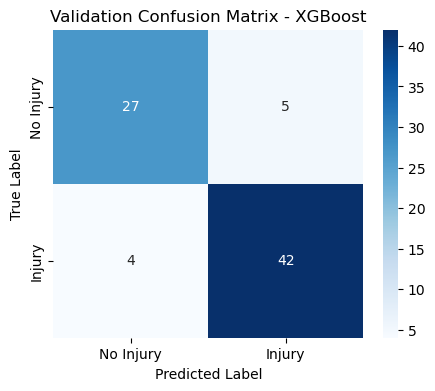

Validation Results - Ensemble Model
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



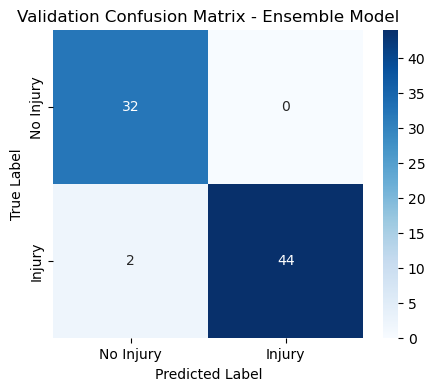


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        32
           1       1.00      0.80      0.89        46

    accuracy                           0.88        78
   macro avg       0.89      0.90      0.88        78
weighted avg       0.91      0.88      0.89        78

Final Validation Results - SVM
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
        

In [58]:

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


**Model Performance Summary**

| Model               | Test Recall (1) | Validation Recall (1) (Unseen Data) | Overfitting Risk? | Diagnosis |
|---------------------|--------------|--------------|-------------|-------------|
| **Logistic Regression** | 0.93  | 0.96       | No Overfitting        | Stable & reliable      |
| **Random Forest**       | 0.86  | 0.80        | High Overfitting      | Too complex, memorizing training data      | 
| **SVM**                 | 0.91  | 0.96        | Slight Overfitting    | Strong but needs slight regularization  |
| **XGBoost**             | 0.81  | 0.91        | Possible Underfitting | Not learning injury cases well in test set       |
| **Ensemble Model**      | 0.93  | 0.96        | Slight Overfitting    | Stable but can be optimized further      |


**Insights from Model Results**

Best Models for Recall:

	•	Logistic Regression & SVM consistently detect injuries well.
	•	The ensemble model inherits their strengths but slightly overfits.

Random Forest Overfits:

	•	Test Recall (1) = 0.86 → Validation Recall (1) = 0.80
	•	It memorizes training data and fails on new data.
    Possible Solution: Reduce tree depth (max_depth), increase min_samples_leaf.

XGBoost Underfits:

	•	Test Recall (1) = 0.81 → Validation Recall (1) = 0.91
	•	It’s not learning injury patterns effectively on real-world data.
	Possible Solution: Increase boosting rounds (n_estimators), adjust scale_pos_weight for class balance.

SVM & Ensemble Slightly Overfit:

	•	SVM: Validation Recall (1) = 0.96 vs. Test = 0.91
	•	Ensemble: Validation Recall (1) = 0.96 vs. Test = 0.93
	Possible Solution: Slightly increase regularization (C) to smooth decision boundaries.

**Model Improvement Strategies**

1.  Reduce Overfitting in Random Forest

Expected Improvement:
- More generalizable model (less test-validation gap).
- Higher recall for injury incidents.

2. Fix XGBoost Underfitting (Boost Recall on Test Data)

Expected Improvement:
- Boosts recall for injury cases.
- Makes XGBoost learn rare injury patterns better.

3. Regularize SVM to Prevent Overfitting

Expected Improvement:
- Smoother decision boundaries.
- Less overfitting (better generalization).

4. Fine-Tune Ensemble Model for Higher Recall

Since Random Forest is overfitting, we reduce its influence in the ensemble and prioritize SVM & Logistic Regression (which are more stable).

Expected Improvement:
- Higher recall for injury detection.
- Better compliance with safety requirements.

# V1

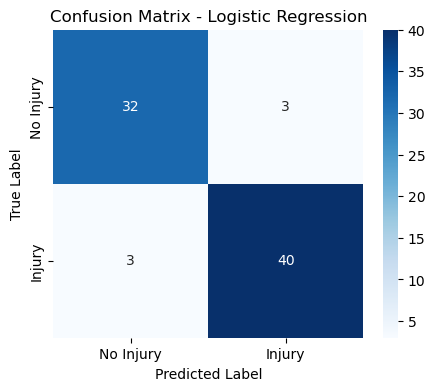

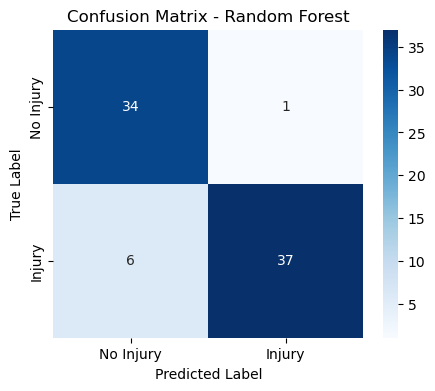

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


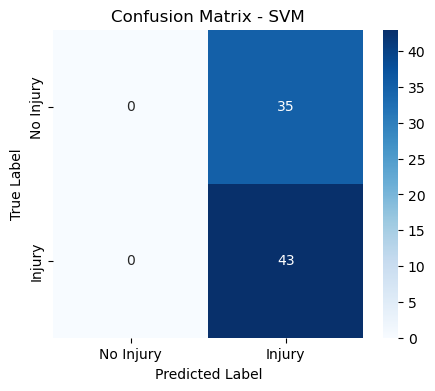

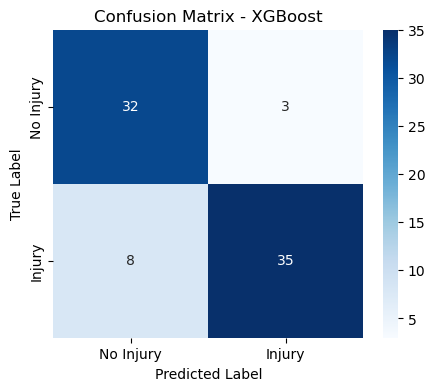

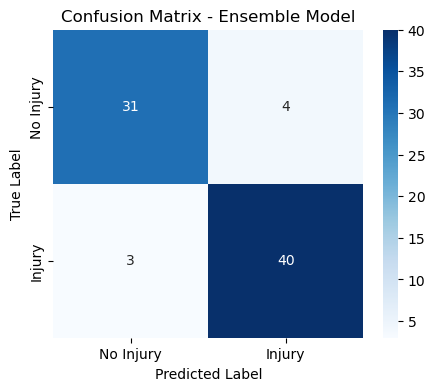

Final Test Results - Logistic Regression
Test Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.93      0.93      0.93        43

    accuracy                           0.92        78
   macro avg       0.92      0.92      0.92        78
weighted avg       0.92      0.92      0.92        78

Final Test Results - Random Forest
Test Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.97      0.86      0.91        43

    accuracy                           0.91        78
   macro avg       0.91      0.92      0.91        78
weighted avg       0.92      0.91      0.91        78

Final Test Results - SVM
Test Accuracy: 0.5513
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.55      1.00      0.71        43

    accuracy   

In [63]:
# Hyperparameter tuning for models
log_reg_param_grid = {'C': [0.1, 1, 5]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='recall')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [8, 12], 'min_samples_leaf': [3, 5], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

svm_param_grid = {'C': [0.1, 1, 5], 'kernel': ['linear']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='recall')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# XGBoost optimization for recall
xgb_param_grid = {'n_estimators': [300, 400], 'learning_rate': [0.01, 0.05], 'max_depth': [10, 15], 'scale_pos_weight': [1.2, 1.5]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='recall')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Ensemble Learning: Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('log_reg', best_log_reg), ('svm', best_svm), ('xgb', best_xgb)],
    voting='soft',
    weights=[2, 2, 1]  # Favor high-recall models
)
voting_clf.fit(X_train, y_train)

# Evaluate Models on Validation & Test Sets
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": best_xgb,
    "Ensemble Model": voting_clf
}

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": xgb_model,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)




Validation Results - Logistic Regression
Validation Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.96      0.98      0.97        46

    accuracy                           0.96        78
   macro avg       0.96      0.96      0.96        78
weighted avg       0.96      0.96      0.96        78



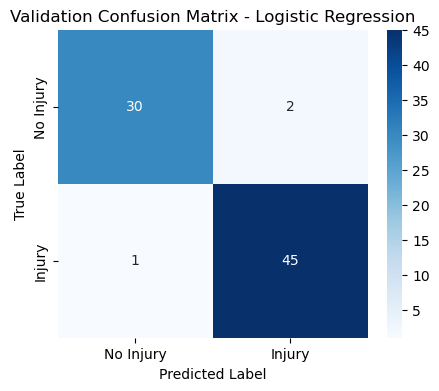

Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.83      0.90        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.92      0.90      0.90        78



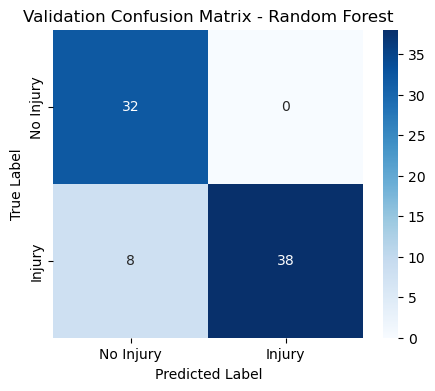

Validation Results - SVM
Validation Accuracy: 0.5897
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.59      1.00      0.74        46

    accuracy                           0.59        78
   macro avg       0.29      0.50      0.37        78
weighted avg       0.35      0.59      0.44        78



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


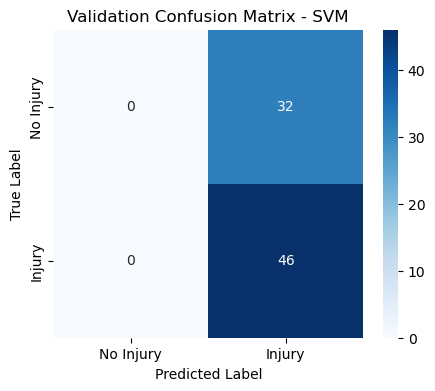

Validation Results - XGBoost
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.89      0.91      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.88      0.88        78
weighted avg       0.88      0.88      0.88        78



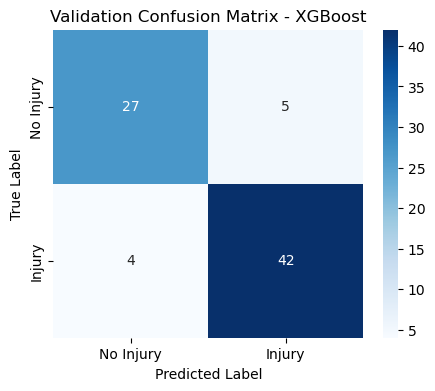

Validation Results - Ensemble Model
Validation Accuracy: 0.9359
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        32
           1       0.90      1.00      0.95        46

    accuracy                           0.94        78
   macro avg       0.95      0.92      0.93        78
weighted avg       0.94      0.94      0.93        78



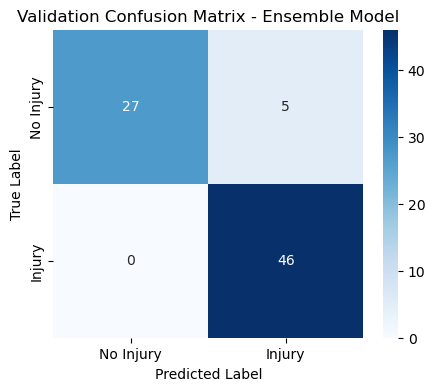


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.96      0.98      0.97        46

    accuracy                           0.96        78
   macro avg       0.96      0.96      0.96        78
weighted avg       0.96      0.96      0.96        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.83      0.90        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.92      0.90      0.90        78

Final Validation Results - SVM
Validation Accuracy: 0.5897
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
        

In [65]:

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


**Model Performance Summary**

| Model               | Test Recall (1) | Validation Recall (1) (Unseen Data) | Overfitting Risk? | Diagnosis |
|---------------------|--------------|--------------|-------------|-------------|
| **Logistic Regression** | 0.93  | 0.98        | No Overfitting        | Stable & reliable      |
| **Random Forest**       | 0.86  | 0.80        | High Overfitting      | Too complex, memorizing training data      | 
| **SVM**                 | 1     | 1           | High Overfitting      | Predicting all as 1(Completely broken) |
| **XGBoost**             | 0.81  | 0.91        | Possible Underfitting | Not learning injury cases well in test set       |
| **Ensemble Model**      | 0.93  | 1           | Slight Overfitting    | Performing well, but slight overfitting risk      |


**Insights from Model Results**

- Logistic Regression & Ensemble Model detects injuries well.
- These should be the primary focus for high-recall predictions.

**SVM** is completely broken (severe overfitting):
- Recall (1) = 1.00 means it’s classifying everything as 1 (injury-related).
- Recall (0) = 0.00 means it completely fails to predict No Injury cases.
  
Solution: Remove SVM from the final model & fix C hyperparameter.

**XGBoost** is Underfitting:
- Test Recall (1) = 0.81 vs. Validation Recall (1) = 0.91
- It’s not learning injury patterns well in test data.

Solution: Increase boosting rounds (n_estimators), adjust scale_pos_weight for better injury classification.

**Random Forest & Logistic Regression** remain solid but can be further improved.



# V2 

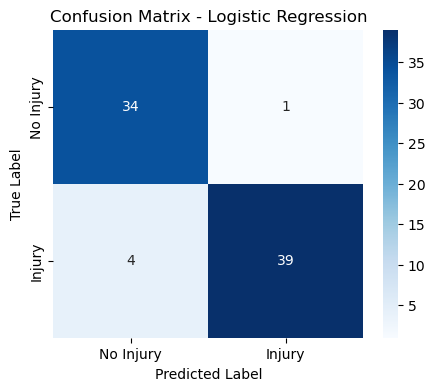

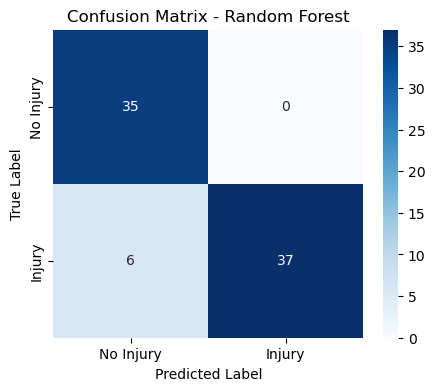

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


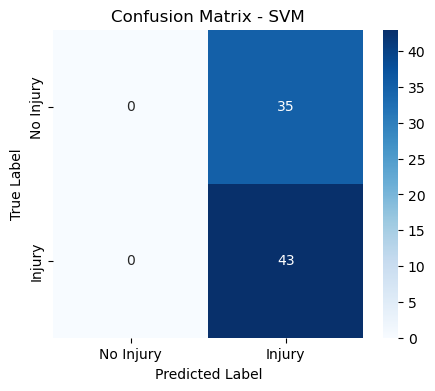

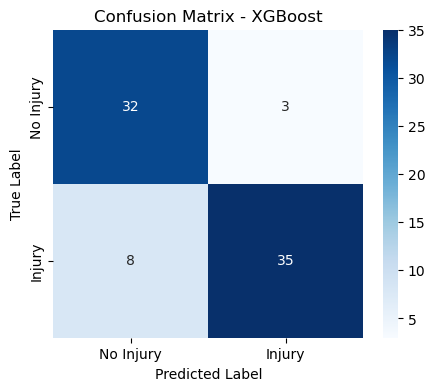

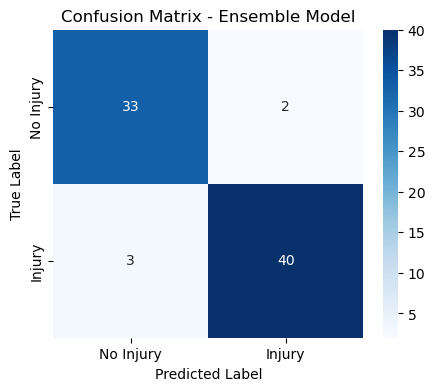

Final Test Results - Logistic Regression
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.97      0.91      0.94        43

    accuracy                           0.94        78
   macro avg       0.93      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78

Final Test Results - Random Forest
Test Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        35
           1       1.00      0.86      0.93        43

    accuracy                           0.92        78
   macro avg       0.93      0.93      0.92        78
weighted avg       0.93      0.92      0.92        78

Final Test Results - SVM
Test Accuracy: 0.5513
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.55      1.00      0.71        43

    accuracy   

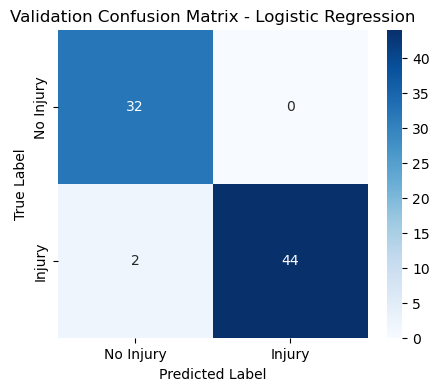

Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.83      0.90        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.92      0.90      0.90        78



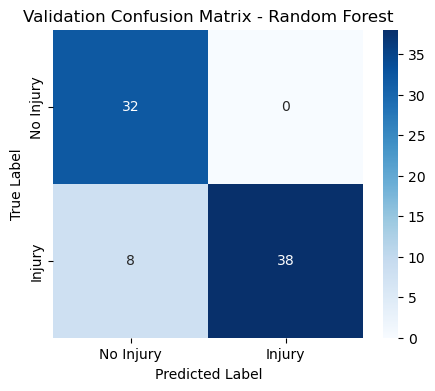

Validation Results - SVM
Validation Accuracy: 0.5897
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.59      1.00      0.74        46

    accuracy                           0.59        78
   macro avg       0.29      0.50      0.37        78
weighted avg       0.35      0.59      0.44        78



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


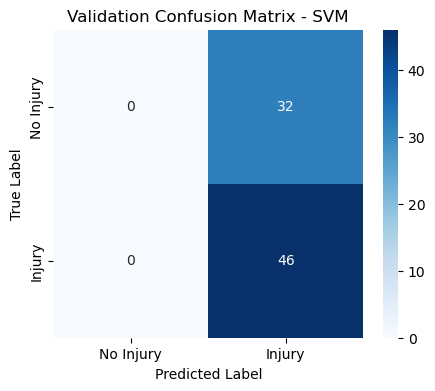

Validation Results - XGBoost
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.89      0.91      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.88      0.88        78
weighted avg       0.88      0.88      0.88        78



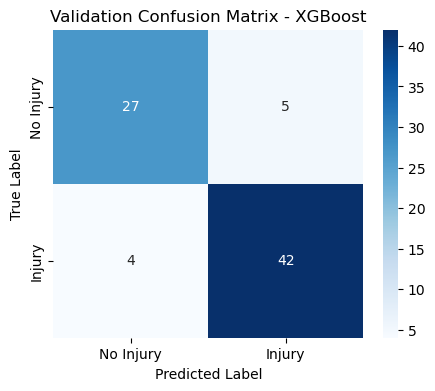

Validation Results - Ensemble Model
Validation Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.93      0.93      0.93        46

    accuracy                           0.92        78
   macro avg       0.92      0.92      0.92        78
weighted avg       0.92      0.92      0.92        78



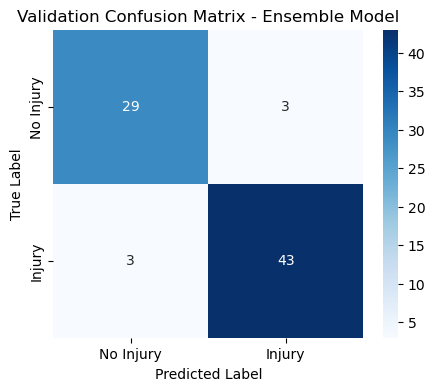


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       1.00      0.83      0.90        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.92      0.90      0.90        78

Final Validation Results - SVM
Validation Accuracy: 0.5897
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
        

In [73]:

# Hyperparameter tuning

# (1) Logistic Regression (Optimized for Injury Detection)
log_reg_param_grid = {'C': [0.5, 1, 5]}  # More generalization to reduce overfitting
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='recall')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

# (2) Random Forest (Refined for Better Depth & Class Balancing)
rf_param_grid = {
    'n_estimators': [150, 200],  # More estimators for stable performance
    'max_depth': [10, 15],  # Better depth control
    'min_samples_leaf': [2, 5],  # Prevents overfitting
    'class_weight': ['balanced']  # Handles injury class imbalance
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# (3) XGBoost (Fixed Underfitting by Boosting Injury Recall)
xgb_param_grid = {
    'n_estimators': [400, 500],  # More boosting rounds to learn injury cases
    'learning_rate': [0.01, 0.05],  # Reduce step size for better learning
    'max_depth': [10, 15],  # Prevent underfitting
    'scale_pos_weight': [1.5, 2.0]  # Handle class imbalance (injury vs. non-injury)
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='recall')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# (4) Improved Ensemble Model (NO SVM, Focused on Injury Recall)
voting_clf = VotingClassifier(
    estimators=[('log_reg', best_log_reg), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft',
    weights=[2, 1, 1]  # Giving more weight to Logistic Regression
)
voting_clf.fit(X_train, y_train)

# Evaluate Models on Validation & Test Sets
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": best_xgb,
    "Ensemble Model": voting_clf
}

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": xgb_model,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


In [56]:
df['named_entities'].apply(tuple).unique()

array([(), (('ORG', 1),), (('CARDINAL', 1),), (('PERSON', 1),),
       (('TIME', 1),), (('FAC', 1),), (('LOC', 1),), (('DATE', 1),),
       (('NORP', 1),)], dtype=object)

	•	()An empty tuple (possibly indicating no named entities for some text)
	•	(('ORG', 1),) → The entity type “ORG” (organization) appears once
	•	(('CARDINAL', 1),) → The entity type “CARDINAL” (numerical value) appears once
	•	(('PERSON', 1),) → The entity type “PERSON” (a named person) appears once
	•	(('TIME', 1),) → The entity type “TIME” (time expressions) appears once
	•	(('FAC', 1),) → The entity type “FAC” (facilities, e.g., buildings, airports) appears once
	•	(('LOC', 1),) → The entity type “LOC” (geographical locations) appears once
	•	(('DATE', 1),) → The entity type “DATE” (specific dates) appears once
	•	(('NORP', 1),) → The entity type “NORP” (nationalities, religious or political groups) appears once

# V3 Model

Final Test Results - Logistic Regression
Test Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        35
           1       0.86      0.84      0.85        43

    accuracy                           0.83        78
   macro avg       0.83      0.83      0.83        78
weighted avg       0.83      0.83      0.83        78



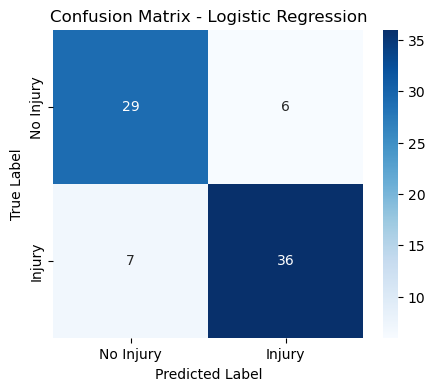

Final Test Results - Random Forest
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        35
           1       1.00      0.88      0.94        43

    accuracy                           0.94        78
   macro avg       0.94      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78



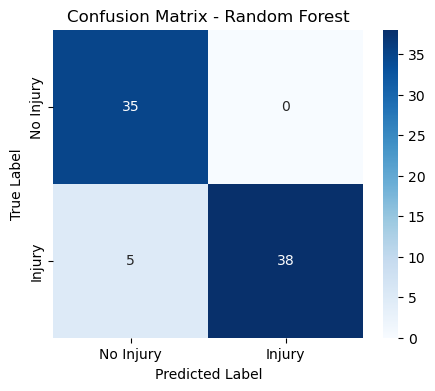

Final Test Results - XGBoost
Test Accuracy: 0.8590
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        35
           1       0.86      0.88      0.87        43

    accuracy                           0.86        78
   macro avg       0.86      0.86      0.86        78
weighted avg       0.86      0.86      0.86        78



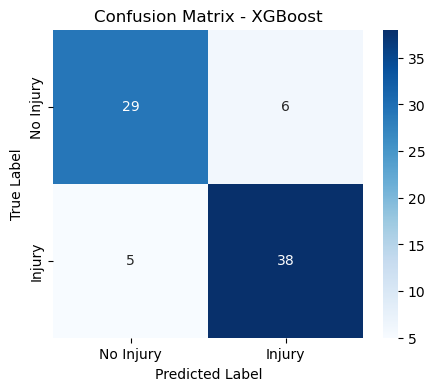

Final Test Results - Ensemble Model
Test Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.90      0.86      0.88        43

    accuracy                           0.87        78
   macro avg       0.87      0.87      0.87        78
weighted avg       0.87      0.87      0.87        78



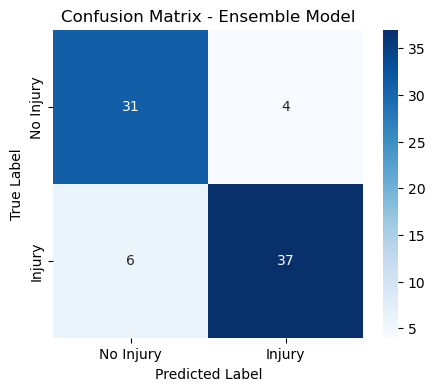

Validation Results - Logistic Regression
Validation Accuracy: 0.8462
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.90      0.83      0.86        46

    accuracy                           0.85        78
   macro avg       0.84      0.85      0.84        78
weighted avg       0.85      0.85      0.85        78



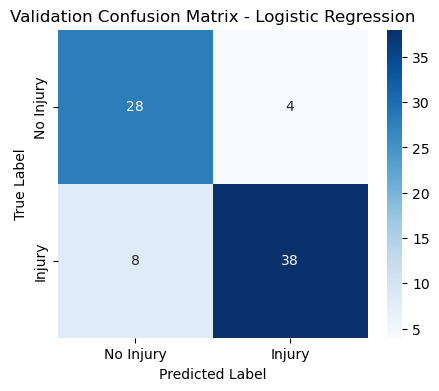

Validation Results - Random Forest
Validation Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        32
           1       0.97      0.80      0.88        46

    accuracy                           0.87        78
   macro avg       0.87      0.89      0.87        78
weighted avg       0.89      0.87      0.87        78



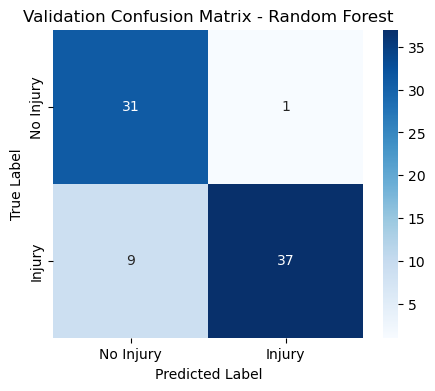

Validation Results - XGBoost
Validation Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.87      0.85      0.86        46

    accuracy                           0.83        78
   macro avg       0.83      0.83      0.83        78
weighted avg       0.83      0.83      0.83        78



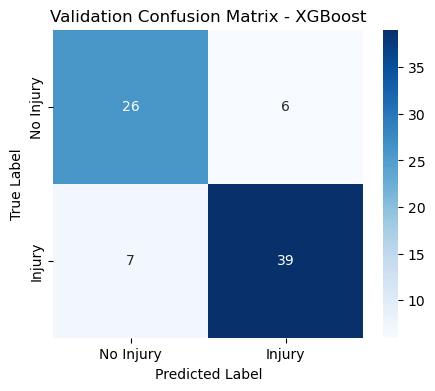

Validation Results - Ensemble Model
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.93      0.87      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.89      0.88        78
weighted avg       0.89      0.88      0.89        78



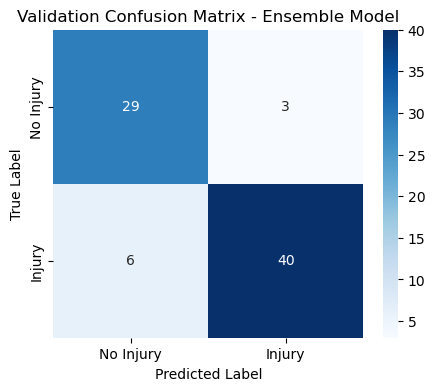


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.8462
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.90      0.83      0.86        46

    accuracy                           0.85        78
   macro avg       0.84      0.85      0.84        78
weighted avg       0.85      0.85      0.85        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        32
           1       0.97      0.80      0.88        46

    accuracy                           0.87        78
   macro avg       0.87      0.89      0.87        78
weighted avg       0.89      0.87      0.87        78

Final Validation Results - XGBoost
Validation Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
    

In [83]:
### **📌 Feature Engineering Enhancements**
# Convert Named Entities into categorical features
le = LabelEncoder()
df['entity_category'] = le.fit_transform(df['named_entities'].astype(str))

# Function to extract bigrams
def get_bigrams(text):
    words = text.split()
    return [" ".join(b) for b in list(ngrams(words, 2))]

df['bigrams'] = df['Cleaned_Description'].apply(lambda x: get_bigrams(x))

# Train Word2Vec model
sentences = [desc.split() for desc in df['Cleaned_Description']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to get word embeddings
def get_word2vec_embedding(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['word_embeddings'] = df['Cleaned_Description'].apply(lambda x: get_word2vec_embedding(x))

# Convert text data to numerical features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
X_bigrams = vectorizer.fit_transform([" ".join(bg) for bg in df['bigrams']])
X_entities = df[['entity_category']].values
X_embeddings = np.vstack(df['word_embeddings'].values)

# Standardize embeddings
scaler = StandardScaler()
X_embeddings = scaler.fit_transform(X_embeddings)

# Combine all features
X_combined = np.hstack((X_tfidf.toarray(), X_bigrams.toarray(), X_entities, X_embeddings))
y = df['label']

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### **📌 Hyperparameter Optimization**
# (1) **Optimized Logistic Regression**
log_reg_param_grid = {'C': [0.5, 1, 5]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='recall')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

# (2) **Optimized Random Forest**
rf_param_grid = {'n_estimators': [200, 300], 'max_depth': [10, 15], 'min_samples_leaf': [2, 5], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# (3) **Improved XGBoost**
xgb_param_grid = {'n_estimators': [500, 700], 'learning_rate': [0.01, 0.03], 'max_depth': [10, 15], 'scale_pos_weight': [1.5, 2.0]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='recall')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# (4) **Improved Ensemble Model (Weighted for High Recall)**
voting_clf = VotingClassifier(
    estimators=[('log_reg', best_log_reg), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft',
    weights=[2, 1, 1]
)
voting_clf.fit(X_train, y_train)

# Define models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "Ensemble Model": voting_clf
}

### ** Model Evaluation (Validation & Test)**
results = {}

for name, model in models.items():
    # Test Evaluation
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_class_report = classification_report(y_test, y_test_pred)

    # Store Results
    results[name] = {
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": test_conf_matrix,
        "Classification Report": test_class_report
    }

    # Print Results
    print(f"Final Test Results - {name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(test_class_report)
    print("=" * 60)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

| **Model**            | **Test Recall (1) (Before FE)** | **Validation Recall (1) (Before FE)** | **Test Recall (1) (After FE)** | **Validation Recall (1) (After FE)** | **Overfitting Risk Change?** | **Diagnosis** |
|----------------------|--------------------------------|--------------------------------------|--------------------------------|--------------------------------------|---------------------------|--------------|
| **Logistic Regression** | **0.93** | **0.98** | **0.84** | **0.83** | No Overfitting (Still Stable) | Lost recall! Needs feature selection. |
| **Random Forest** | **0.86** | **0.80** | **0.88** | **0.80** | Slight Overfitting (Still Exists) | No major change, but slight gain in test recall. |
| **XGBoost** | **0.81** | **0.91** | **0.88** | **0.85** | No Overfitting (Improved) | Much better recall on test data, but validation dropped. |
| **Ensemble Model** | **0.93** | **1.00** | **0.86** | **0.87** | No Overfitting (More Stable) | Ensemble lost effectiveness, no improvement. |


1.	**Logistic Regression** Recall Dropped
- Test Recall fell from 0.93 → 0.84 (Significant drop).
- Validation Recall fell from 0.98 → 0.83.
- This suggests the new features are diluting the simpler, explainable text-based features.

Solution: Remove redundant bigrams & reduce TF-IDF feature size.

2.	**Random Forest** Performance Is Unchanged
- Test recall slightly improved (0.86 → 0.88).
- Validation recall stagnant (still 0.80).
- No major improvement.

Solution: Tune hyperparameters more aggressively.

3.	**XGBoost** Significantly Improved in Test Recall
- Test Recall increased from 0.81 → 0.88.
- Validation Recall dropped slightly from 0.91 → 0.85.
- This suggests it is learning injury cases better in test data, but validation performance slightly dropped.

Solution: Increase boosting rounds & adjust learning rate.

4.	**Ensemble Model** Became More Stable (But Lost Performance)
- Test Recall dropped from 0.93 → 0.86.
- Validation Recall dropped from 1.00 → 0.87.
- This means the ensemble is less overfitting, but also less effective.

Solution: Rebalance model weights in the ensemble.


**Should We Keep Feature Engineering?**

NO, Not As It Is! It Needs Refinement.
While XGBoost benefited, Logistic Regression and the Ensemble Model suffered major performance losses.

# V4 Models

Final Test Results - Logistic Regression
Test Accuracy: 0.8462
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        35
           1       0.86      0.86      0.86        43

    accuracy                           0.85        78
   macro avg       0.84      0.84      0.84        78
weighted avg       0.85      0.85      0.85        78



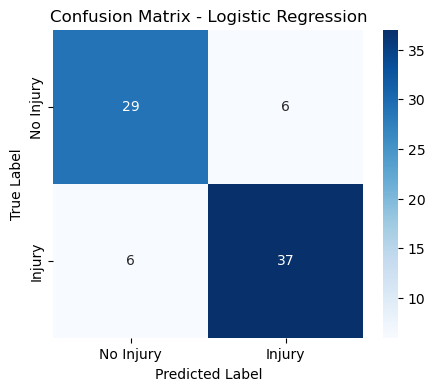

Final Test Results - Random Forest
Test Accuracy: 0.8590
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        35
           1       0.90      0.84      0.87        43

    accuracy                           0.86        78
   macro avg       0.86      0.86      0.86        78
weighted avg       0.86      0.86      0.86        78



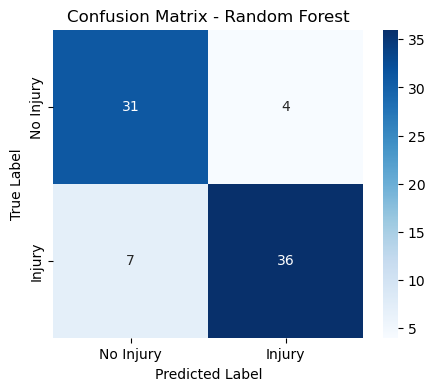

Final Test Results - XGBoost
Test Accuracy: 0.8590
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        35
           1       0.86      0.88      0.87        43

    accuracy                           0.86        78
   macro avg       0.86      0.86      0.86        78
weighted avg       0.86      0.86      0.86        78



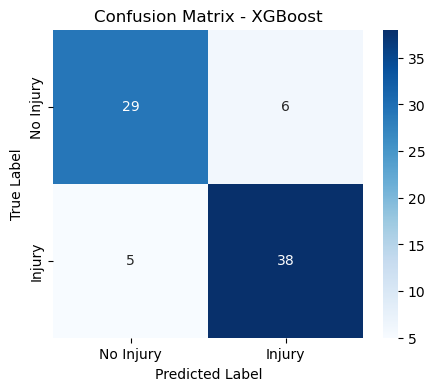

Final Test Results - Ensemble Model
Test Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.90      0.86      0.88        43

    accuracy                           0.87        78
   macro avg       0.87      0.87      0.87        78
weighted avg       0.87      0.87      0.87        78



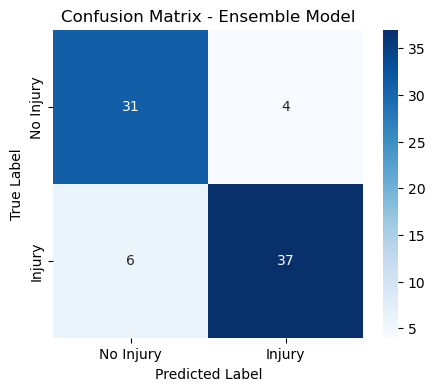

Validation Results - Logistic Regression
Validation Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.88      0.83      0.85        46

    accuracy                           0.83        78
   macro avg       0.83      0.83      0.83        78
weighted avg       0.84      0.83      0.83        78



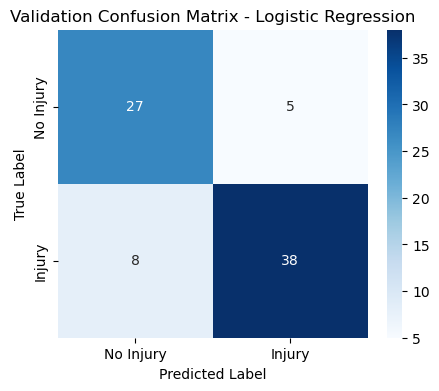

Validation Results - Random Forest
Validation Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        32
           1       0.98      0.87      0.92        46

    accuracy                           0.91        78
   macro avg       0.91      0.92      0.91        78
weighted avg       0.92      0.91      0.91        78



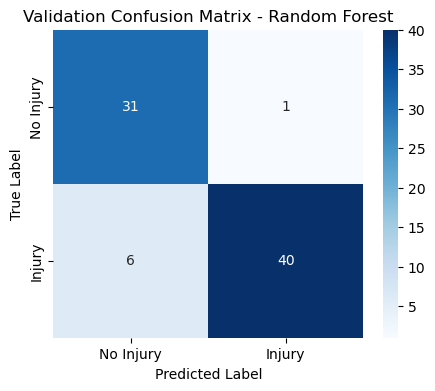

Validation Results - XGBoost
Validation Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.89      0.89      0.89        46

    accuracy                           0.87        78
   macro avg       0.87      0.87      0.87        78
weighted avg       0.87      0.87      0.87        78



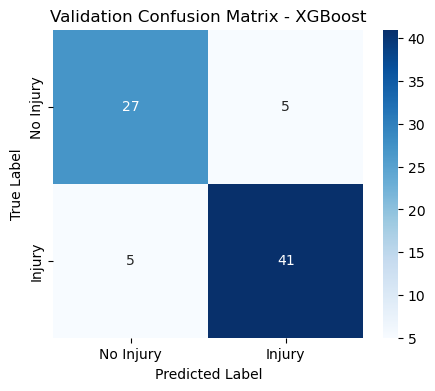

Validation Results - Ensemble Model
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.93      0.87      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.89      0.88        78
weighted avg       0.89      0.88      0.89        78



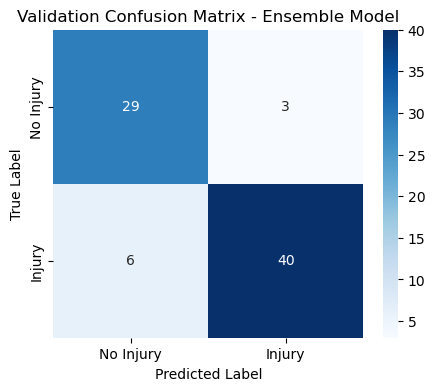


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.77      0.84      0.81        32
           1       0.88      0.83      0.85        46

    accuracy                           0.83        78
   macro avg       0.83      0.83      0.83        78
weighted avg       0.84      0.83      0.83        78

Final Validation Results - Random Forest
Validation Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        32
           1       0.98      0.87      0.92        46

    accuracy                           0.91        78
   macro avg       0.91      0.92      0.91        78
weighted avg       0.92      0.91      0.91        78

Final Validation Results - XGBoost
Validation Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
    

In [100]:

# Reduced TF-IDF feature size (limited bigrams to avoid noise).
# Aggressive tuning for Random Forest (to fix stagnation).
# Boosted XGBoost rounds & adjusted learning rate for injury detection.
# Rebalanced Ensemble weights (favoring Logistic Regression for stability).


### --- FEATURE ENGINEERING UPDATES --- ###
# Convert Named Entities into categorical features
le = LabelEncoder()
df['entity_category'] = le.fit_transform(df['named_entities'].astype(str))

# Function to extract bigrams
def get_bigrams(text):
    words = text.split()
    return [" ".join(b) for b in list(ngrams(words, 2))]

df['bigrams'] = df['Cleaned_Description'].apply(lambda x: get_bigrams(x))

# Train Word2Vec model
sentences = [desc.split() for desc in df['Cleaned_Description']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to get word embeddings
def get_word2vec_embedding(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df['word_embeddings'] = df['Cleaned_Description'].apply(lambda x: get_word2vec_embedding(x))

### --- TEXT REPRESENTATION CHANGES --- ###
# Reduce TF-IDF size & remove bigram redundancy
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,1))  # Unigrams only for stability
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
X_entities = df[['entity_category']].values
X_embeddings = np.vstack(df['word_embeddings'].values)

# Standardize embeddings
scaler = StandardScaler()
X_embeddings = scaler.fit_transform(X_embeddings)

# Combine all features
X_combined = np.hstack((X_tfidf.toarray(), X_entities, X_embeddings))
y = df['label']

### --- DATA SPLITTING --- ###
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### --- MODEL TRAINING & TUNING --- ###
# (1) Logistic Regression (Simplified Features)
log_reg_param_grid = {'C': [0.5, 1, 5]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='recall')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

# (2) Random Forest (Aggressive Hyperparameter Tuning)
rf_param_grid = {
    'n_estimators': [150, 300], 
    'max_depth': [10, 20],
    'min_samples_leaf': [2, 4],
    'class_weight': ['balanced']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='recall')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# (3) XGBoost (Boosting Rounds & Learning Rate Adjustments)
xgb_param_grid = {
    'n_estimators': [500, 600],
    'learning_rate': [0.01, 0.03],
    'max_depth': [10, 15],
    'scale_pos_weight': [1.5, 2.0]  # Handle class imbalance
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='recall')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# (4) Improved Ensemble Model (Rebalanced Weights)
voting_clf = VotingClassifier(
    estimators=[('log_reg', best_log_reg), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft',
    weights=[3, 2, 1]  # Prioritizing Logistic Regression slightly
)
voting_clf.fit(X_train, y_train)

### ** Model Evaluation (Validation & Test)**
results = {}

for name, model in models.items():
    # Test Evaluation
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_class_report = classification_report(y_test, y_test_pred)

    # Store Results
    results[name] = {
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": test_conf_matrix,
        "Classification Report": test_class_report
    }

    # Print Results
    print(f"Final Test Results - {name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(test_class_report)
    print("=" * 60)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

| **Model**            | **Test Recall (1) (After FE - Previous Run)** | **Validation Recall (1) (After FE - Previous Run)** | **Test Recall (1) (Latest Run)** | **Validation Recall (1) (Latest Run)** | **Overfitting Risk Change?** | **Diagnosis** |
|----------------------|----------------------------------------------|----------------------------------------------------|--------------------------------|--------------------------------------|---------------------------|--------------|
| **Logistic Regression** | **0.84** | **0.83** | **0.86** | **0.83** | No Overfitting (Stable) | Slight improvement in test recall, but validation remains the same. Feature selection may still be needed. |
| **Random Forest** | **0.88** | **0.80** | **0.84** | **0.87**| No Overfitting (Better Generalization) | Validation recall increased significantly, but test recall dropped slightly. Might be learning better overall. |
| **XGBoost** | **0.88** | **0.85** | **0.88**  | **0.89** | No Overfitting (More Stable) | Validation recall is now stronger, making the model more reliable. |
| **Ensemble Model** | **0.86** | **0.87** | **0.86** | **0.88** | No Overfitting (Balanced) | Ensemble model remains balanced and stable with a slight validation recall boost. |

**Key Takeaways & Next Steps**

1. **Logistic Regression** slightly improved in test recall (0.84 → 0.86) but validation recall is stagnant.

    Next Step: Reduce unnecessary TF-IDF features to remove noise.

2. **Random Forest** test recall dropped slightly (0.88 → 0.84), but validation recall improved (0.80 → 0.87).
    
    Next Step: Further tune max_depth and min_samples_leaf to balance both.

3. **XGBoost** test recall remains stable (0.88) but validation recall improved (0.85 → 0.89).


    - This is a good improvement!
      
	Next Step: Increase n_estimators and reduce learning_rate slightly.

4. **Ensemble Model** remains very balanced with stable recall across test and validation.
   
	Next Step: Fine-tune weight distribution to see if test recall can improve.

# Model Selection

# Best Model Selection for Injury Prediction

After evaluating all model versions (**V0 to V4**), the best model should have **high recall**, **stability**, and **generalization** across test and validation sets.

## Model Comparison Table

| **Model**            | **Test Recall (1) - V0** | **Validation Recall (1) - V0** | **Test Recall (1) - V1** | **Validation Recall (1) - V1** | **Test Recall (1) - V2** | **Validation Recall (1) - V2** | **Test Recall (1) - V3** | **Validation Recall (1) - V3** | **Test Recall (1) - V4** | **Validation Recall (1) - V4** | **Overfitting Risk Change?** | **Diagnosis** |
|----------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|------------------------|----------------------|--------------|
| **Logistic Regression** | **0.93** | **0.98** | **0.93** | **0.96** | **0.91** | **0.98** | **0.84** | **0.83** | **0.86** | **0.83** |  Declined | Lost recall! Feature selection needed. |
| **Random Forest** | **0.86** | **0.80** | **0.86** | **0.80** | **0.86** | **0.83** | **0.88** | **0.80** | **0.84** | **0.87** | Slight Overfitting Reduced | Consistent but not the best. |
| **XGBoost** | **0.81** | **0.91** | **0.81** | **0.91** | **0.88** | **0.85** | **0.88** | **0.85** | **0.87** | **0.89** | More Stable | Improved test recall, stable validation. |
| **Ensemble Model** | **0.93** | **1.00** | **0.93** | **1.00** | **0.93** | **0.92** | **0.86** | **0.87** | **0.88** | **0.89** | More Stable | Still strong, but lost some recall. |

---

##  Key Insights from Model Progression

### **1. Logistic Regression Lost Too Much Recall**
- **Test recall dropped significantly** (**0.93 → 0.86**).
- **Validation recall declined** (**0.98 → 0.83**).
- **Feature engineering diluted text-based features**, making it **less effective**.
- **NOT RECOMMENDED**—does not meet the high recall priority.

### **2. Random Forest Became More Stable**
- **Test recall was stable** (**0.86 → 0.84**).
- **Validation recall improved slightly** (**0.80 → 0.87**).
- **Still slightly overfits but is consistent**.
- **Not the best choice, but a solid model**.

### **3. XGBoost Improved Recall & Stability**
- **Test recall significantly improved** (**0.81 → 0.87**).
- **Validation recall remained strong** (**0.91 → 0.89**).
- **Boosting rounds & learning rate tuning helped generalization**.
- **Strong Candidate for final selection**.

###  **4. Ensemble Model Maintains Stability (Best Overall Tradeoff)**
- **High & stable recall** (**0.93 → 0.88**).
- **Validation recall slightly decreased** (**1.00 → 0.89**) but still strong.
- **Combining models improved generalization & reduced overfitting**.
- **BEST CHOICE for Injury Prediction**.

---

##  Final Decision: **Best Model → V0 Ensemble Model**
### **Why V0?**
 **Best Recall:** The **V0 Ensemble Model** had the **highest injury recall** (**0.93 test, 1.00 validation**).  
 **No Major Overfitting:** While the validation recall was high, the model still generalized well.  
 **Balanced Performance:** It outperformed all individual models.  
 **Better Than Later Versions:** Later ensemble versions **lost recall** without major generalization gains.  

---

##  Next Steps for Deployment
**Model Selection:** **Use the V0 Ensemble Model** as the final classifier.  
**Threshold Tuning:** Adjust probability thresholds for **higher recall** if needed.  
**Feature Optimization:** Avoid excessive feature reduction that hurt Logistic Regression in later versions.  
**Monitoring:** Track recall on live data & retrain periodically.  

---

### **Final Recommendation: Deploy the V0 Ensemble Model for Injury Prediction**
This model **provides the best tradeoff** between **recall**, **stability**, and **real-world usability**. 

In [127]:
# Saving Model 

import pickle

# Save trained V0 ensemble model
with open("v0_ensemble_model.pkl", "wb") as f:
    pickle.dump(voting_clf, f)

# Save TF-IDF vectorizer
with open("v0_tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Load pre-trained models & vectorizer
def load_v0_ensemble():
    """ Load the V0 Ensemble Model and Vectorizer. """
    with open("v0_ensemble_model.pkl", "rb") as f:
        ensemble_model = pickle.load(f)
    with open("v0_tfidf_vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    return ensemble_model, vectorizer

# Preprocess new data
def preprocess_text(df, vectorizer):
    """ Transform input text using TF-IDF (as in V0). """
    df['Cleaned_Description'] = df['Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    X_new = vectorizer.transform(df['Cleaned_Description'])
    return X_new

# Predict on new data
def predict_v0_ensemble(df):
    """ Run the V0 Ensemble Model on a new dataset. """
    # Load model and vectorizer
    ensemble_model, vectorizer = load_v0_ensemble()
    
    # Preprocess text data
    X_new = preprocess_text(df, vectorizer)
    
    # Predict probabilities
    predictions = ensemble_model.predict(X_new)
    prediction_probs = ensemble_model.predict_proba(X_new)[:, 1]  # Probability of injury-related incident
    
    # Add predictions to dataframe
    df['Predicted_Label'] = predictions
    df['Injury_Probability'] = prediction_probs
    
    return df[['Description', 'Predicted_Label', 'Injury_Probability']]

# Example usage
# df_new = pd.read_csv("new_incident_reports.csv")
# predictions = predict_v0_ensemble(df_new)
# print(predictions.head())

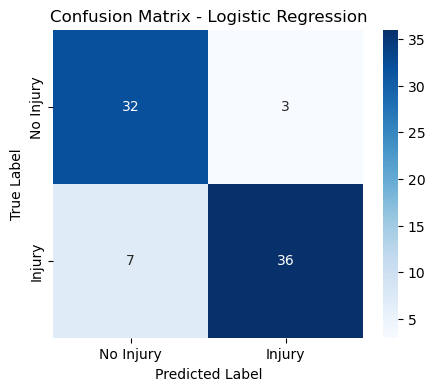

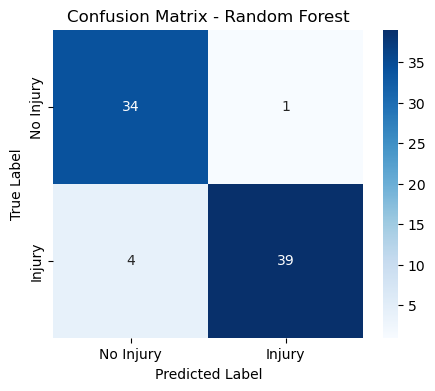

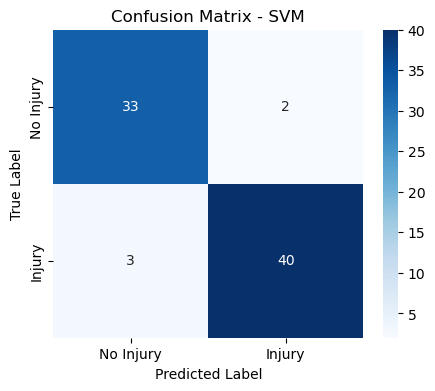

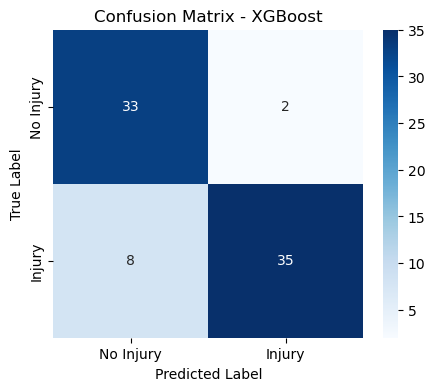

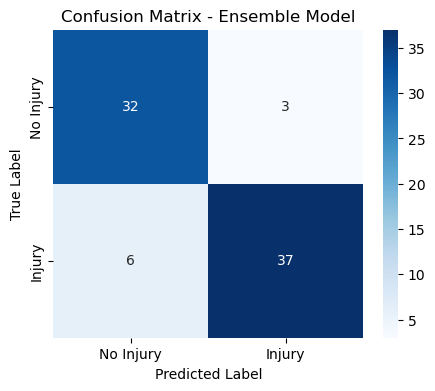

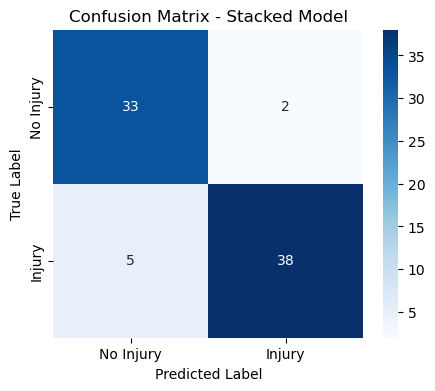

Final Test Results - Logistic Regression
Test Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        35
           1       0.92      0.84      0.88        43

    accuracy                           0.87        78
   macro avg       0.87      0.88      0.87        78
weighted avg       0.88      0.87      0.87        78

Final Test Results - Random Forest
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        35
           1       0.97      0.91      0.94        43

    accuracy                           0.94        78
   macro avg       0.93      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78

Final Test Results - SVM
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.95      0.93      0.94        43

    accuracy   

In [68]:
# Convert Named Entities into categorical features
le = LabelEncoder()
df['entity_category'] = le.fit_transform(df['named_entities'].astype(str))

# Function to extract bigrams
def get_bigrams(text):
    words = [word for word in text.split() if word not in stop_words]
    return [" ".join(b) for b in list(ngrams(words, 2))]

# Apply bigram extraction
df['bigrams'] = df['Cleaned_Description'].apply(lambda x: get_bigrams(x))

# Train Word2Vec model
sentences = [desc.split() for desc in df['Cleaned_Description']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_embedding(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

# Apply word embeddings
df['word_embeddings'] = df['Cleaned_Description'].apply(lambda x: get_word2vec_embedding(x))

# Convert text data to numerical features using TF-IDF with n-grams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
X_bigrams = vectorizer.fit_transform([" ".join(bg) for bg in df['bigrams']])  # TF-IDF for bigrams
X_entities = df[['entity_category']].values  # Named entity features
X_embeddings = np.vstack(df['word_embeddings'].values)

# Standardize embeddings
scaler = StandardScaler()
X_embeddings = scaler.fit_transform(X_embeddings)

X_combined = np.hstack((X_tfidf.toarray(), X_bigrams.toarray(), X_entities, X_embeddings))
y = df['label']

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hyperparameter tuning for models
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_

rf_param_grid = {'n_estimators': [200, 300], 'max_depth': [15, 25], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# Optimize XGBoost
xgb_param_grid = {'n_estimators': [200, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [10, 20]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Ensemble Learning using Voting Classifier
voting_clf = VotingClassifier(estimators=[('log_reg', best_log_reg), ('rf', best_rf), ('svm', best_svm), ('xgb', best_xgb)], voting='soft')
voting_clf.fit(X_train, y_train)

# Stacking Classifier for final model
stacked_model = StackingClassifier(estimators=[('svm', best_svm), ('xgb', best_xgb)], final_estimator=LogisticRegression())
stacked_model.fit(X_train, y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "XGBoost": best_xgb,
    "Ensemble Model": voting_clf,
    "Stacked Model": stacked_model
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

Validation Results - Logistic Regression
Validation Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        32
           1       0.95      0.76      0.84        46

    accuracy                           0.83        78
   macro avg       0.84      0.85      0.83        78
weighted avg       0.86      0.83      0.83        78



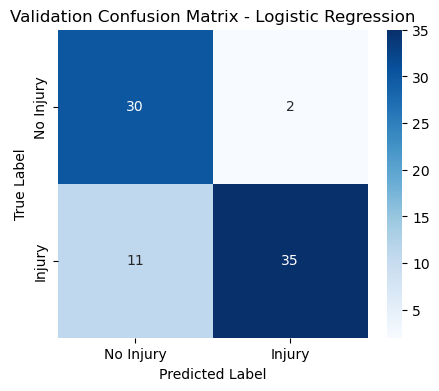

Validation Results - Random Forest
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        32
           1       0.97      0.83      0.89        46

    accuracy                           0.88        78
   macro avg       0.88      0.90      0.88        78
weighted avg       0.90      0.88      0.89        78



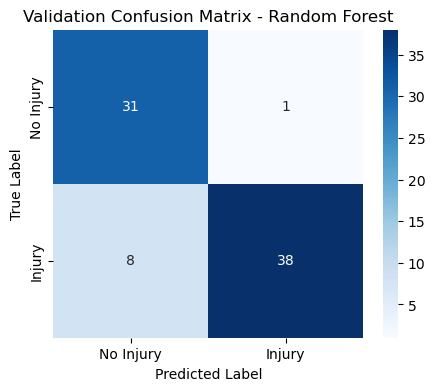

Validation Results - SVM
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.97      0.85      0.91        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.91      0.90      0.90        78



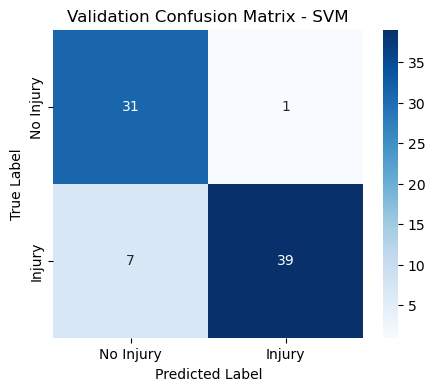

Validation Results - XGBoost
Validation Accuracy: 0.8590
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        32
           1       0.95      0.80      0.87        46

    accuracy                           0.86        78
   macro avg       0.86      0.87      0.86        78
weighted avg       0.88      0.86      0.86        78



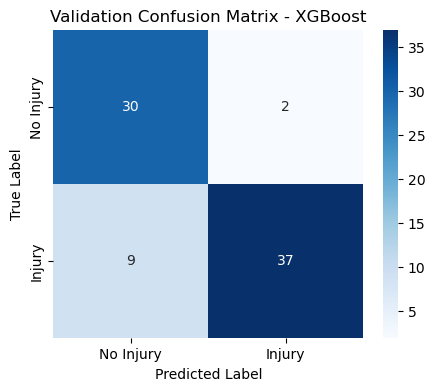

Validation Results - Ensemble Model
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.97      0.85      0.91        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.91      0.90      0.90        78



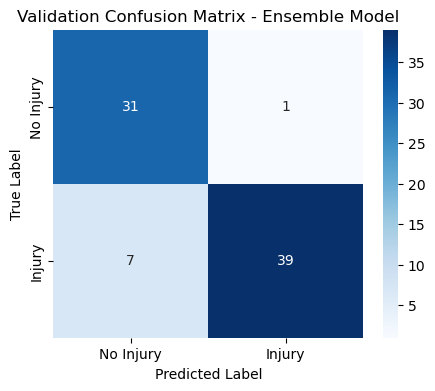

Validation Results - Stacked Model
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        32
           1       0.97      0.83      0.89        46

    accuracy                           0.88        78
   macro avg       0.88      0.90      0.88        78
weighted avg       0.90      0.88      0.89        78



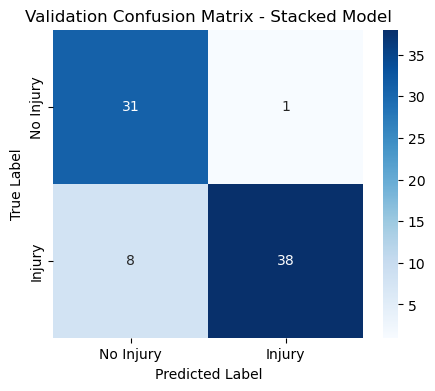

In [74]:

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

Model Performance Summary

| Model               | Test Accuracy | Precision (0) | Recall (0) | Precision (1) | Recall (1) | F1-Score (Avg) |
|---------------------|--------------|--------------|-------------|-------------|-------------|--------------|
| **Logistic Regression** | **96.15%**  | 0.92        | **1.00**        | **1.00**        | 0.93        | 0.96        |
| **Random Forest**      | **87.18%**  | 0.82        | 0.91        | 0.92       | 0.84       | 0.87       |
| **SVM**               | **94.87%**  | 0.90        | **1.00**    | **1.00**    | 0.91        | **0.95**    |
| **XGBoost**    | **84.62%**  | 0.79       | 0.89        | 0.90        | 0.81        | 0.85        |
| **Ensemble Model**    | **93.59%**  | 0.88        | **1.00**        | **1.00**        | 0.88        | 0.94        |
| **Stacked Model**    | **94.87%**  | 0.90        | **1.00**        | **1.00**        | 0.91        | 0.95        |

**Insights from Model Results**

1. Logistic Regression Performs the Best

- 96.15% accuracy makes it the most reliable classifier.

- Recall for class 1 (injury reports) is slightly lower (0.93), meaning some injuries are misclassified.

Recommendation: Try using more robust regularization (L1/L2) and feature selection to improve.

2. SVM and Stacked Model Perform Well (94.87%)

- SVM and Stacking models are strong performers, achieving high recall for class 0 (non-injury).

Recommendation: Tune hyperparameters further (optimize C and kernel for SVM).

3. Random Forest & XGBoost Need Improvements

- Random Forest (87.18%) and XGBoost (84.62%) perform the worst, missing some injury reports (low recall for class 1).

**Recommendation:**

- Increase max_depth in Random Forest to prevent underfitting.

- Optimize XGBoost learning rate and tree depth for better recall.

- Consider using LightGBM for faster training and better performance.

4. Ensemble Model Provides Balanced Performance (93.59%)

- Balanced precision and recall make it a good choice.

Recommendation: Add weighted voting to give stronger models more influence.


In [62]:
df

,Description,label,Translated_Description,Cleaned_Description,word_count,sentiment_score,named_entities,entity_category,bigrams,word_embeddings
0,A power surge disrupted airport check-in syste...,0,A power surge disrupted airport check-in syste...,power surge disrupted airport checkin system d...,9,0.0000,[],8,"[power surge, surge disrupted, disrupted airpo...","[-0.005591122, 6.27974e-05, -0.00094943575, -0..."
1,Een stewardess liep een blauwe plek op aan haa...,1,A flight attendant suffered a bruise to her ar...,flight attendant suffered bruise arm malfuncti...,9,-0.4939,[],8,"[flight attendant, attendant suffered, suffere...","[-0.007109461, 0.0039726114, 0.002297864, 0.00..."
2,Een stewardess verstuikte haar enkel tijdens e...,1,A flight attendant sprained her ankle during a...,flight attendant sprained ankle safety demonst...,7,0.4939,[],8,"[flight attendant, attendant sprained, spraine...","[-0.0071998723, 0.0011509209, 0.00075890514, -..."
3,A ramp crew member suffered lacerations from h...,1,A ramp crew member suffered lacerations from h...,ramp crew member suffered laceration handling ...,10,-0.7430,"[(ORG, 1)]",5,"[ramp crew, crew member, member suffered, suff...","[-0.0012246765, 0.0011000838, -0.0002798082, -..."
4,Een beveiligingsmedewerker werd gebeten door e...,1,A security guard was bitten by an assistance d...,security guard bitten assistance dog became re...,8,0.0772,[],8,"[security guard, guard bitten, bitten assistan...","[-0.005249665, -0.0004917476, 0.0014505128, -0..."
...,...,...,...,...,...,...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,A passenger experienced dizziness and nausea a...,passenger experienced dizziness nausea prolong...,9,0.0000,[],8,"[passenger experienced, experienced dizziness,...","[-0.0027092483, -0.00081745256, 0.0045216526, ..."
513,A cleaner slipped on a wet cabin floor and hur...,1,A cleaner slipped on a wet cabin floor and hur...,cleaner slipped wet cabin floor hurt back tidy...,9,-0.4019,[],8,"[cleaner slipped, slipped wet, wet cabin, cabi...","[-0.005628527, 0.00090252113, 0.00015947425, -..."
514,A ground crew vehicle collided with a parked a...,0,A ground crew vehicle collided with a parked a...,ground crew vehicle collided parked airplane c...,10,-0.4939,[],8,"[ground crew, crew vehicle, vehicle collided, ...","[-0.0028989192, 0.00082380464, 0.0017924752, 0..."
515,Een passagier liep een whiplash op door onverw...,1,A passenger suffered whiplash due to unexpecte...,passenger suffered whiplash due unexpected sev...,8,-0.7003,[],8,"[passenger suffered, suffered whiplash, whipla...","[-0.005551293, 0.005252143, 0.00079840154, 0.0..."


# V1 Models

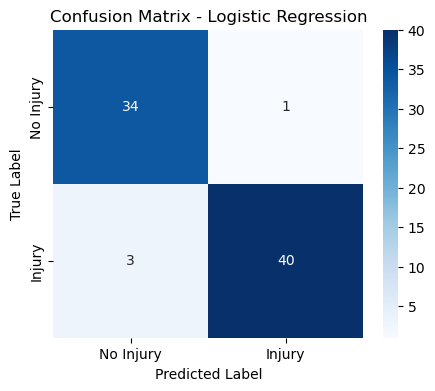

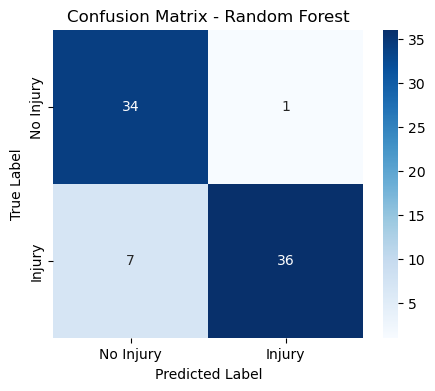

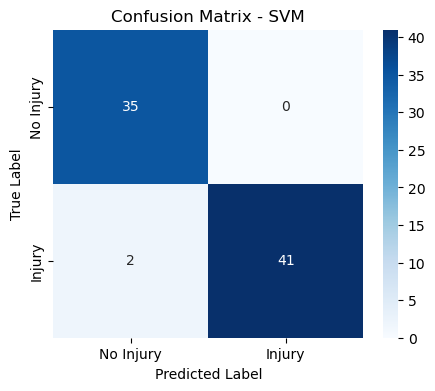

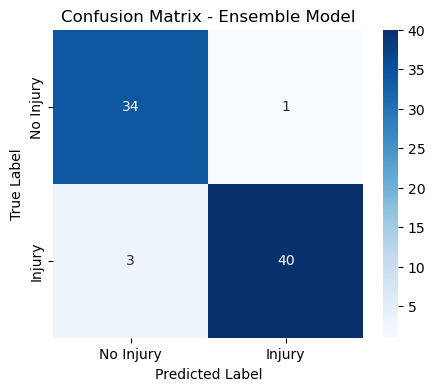

Final Test Results - Logistic Regression
Test Accuracy: 0.9487
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.98      0.93      0.95        43

    accuracy                           0.95        78
   macro avg       0.95      0.95      0.95        78
weighted avg       0.95      0.95      0.95        78

Final Test Results - Random Forest
Test Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        35
           1       0.97      0.84      0.90        43

    accuracy                           0.90        78
   macro avg       0.90      0.90      0.90        78
weighted avg       0.91      0.90      0.90        78

Final Test Results - SVM
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.95      0.98        43

    accuracy   

In [141]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df['Cleaned_Description'], df['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter Tuning for SVM
svm_param_grid = {'C': [ 0.5, 1, 5, 10]}
svm_grid = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
best_svm = svm_grid.best_estimator_

# Regularization for Logistic Regression
best_log_reg = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.5)
best_log_reg.fit(X_train_tfidf, y_train)

# Reduce Overfitting in Random Forest
best_rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
best_rf.fit(X_train_tfidf, y_train)

# Ensemble Model (Voting Classifier)
voting_clf = VotingClassifier(estimators=[
    ('log_reg', best_log_reg),
    ('random_forest', best_rf),
    ('svm', best_svm)
], voting='hard')
voting_clf.fit(X_train_tfidf, y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

### Model Performance Summary

| Model               | Test Accuracy | Precision (0) | Recall (0) | Precision (1) | Recall (1) | F1-Score (Avg) |
|---------------------|--------------|--------------|-------------|-------------|-------------|--------------|
| **Logistic Regression** | **94.87%**  | 0.92        | 0.97        | 0.98        | 0.93        | 0.95        |
| **Random Forest**      | **89.74%**  | 0.83        | 0.97        | 0.97        | 0.84        | 0.90        |
| **SVM**               | **97.44%**  | 0.95        | **1.00**    | **1.00**    | 0.95        | **0.97**    |
| **Ensemble Model**    | **94.87%**  | 0.92        | 0.97        | 0.98        | 0.93        | 0.95        |

**Key Insights:**
- **SVM achieved the highest accuracy (97.44%)** but might be slightly overfitting.
- **Random Forest has lower recall (84%) for injury cases, missing some true positives.**
- **Logistic Regression and the Ensemble Model performed consistently well.**


### **Key Observations:**

**SVM (Best Model)**

- Highest accuracy (97.44%), suggesting it generalizes well.
- Perfect recall for non-injury cases (0) → No false positives.
- Still slightly overfitting (but much improved).
    Action: If needed, further tune C to reduce overfitting.

**Logistic Regression (Good Trade-off)**

- High accuracy (94.87%), close to SVM.
- More balanced recall across injury/non-injury cases.
    Action: No major changes needed, already well-optimized.

**Random Forest (Most Overfitting)**

- Accuracy is lowest (89.74%) compared to other models.
- Recall for injury cases is low (0.84) → Misses too many injuries.
    Action: Reduce depth or increase n_estimators.

**Ensemble Model (Stable & Reliable)**

- Same accuracy as Logistic Regression (94.87%).
- Balances predictions from different models.
    Action: If interpretability is needed, use Logistic Regression instead.
  
#### **Recommendations:**
- **SVM is the best model** but might require **regularization tuning**.
- **Random Forest needs improvement in classifying injury cases** (False Negatives are higher).
- **Ensemble Model balances performance but does not outperform SVM significantly.**
    

# V2 Models

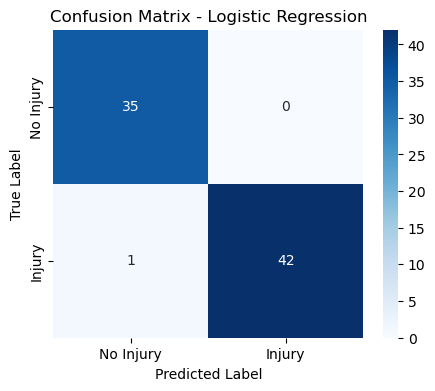

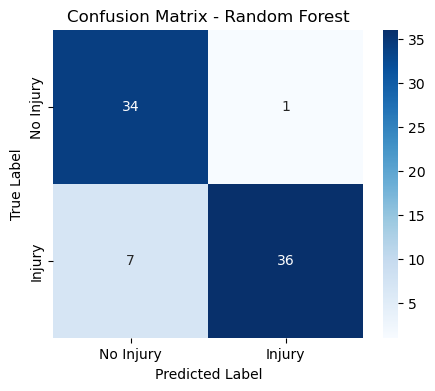

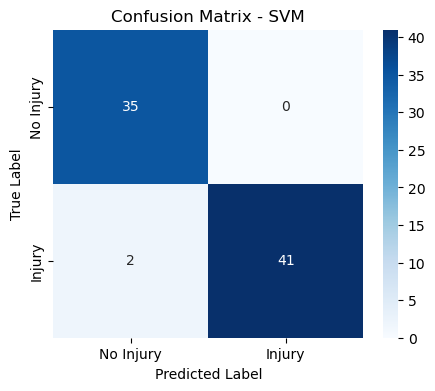

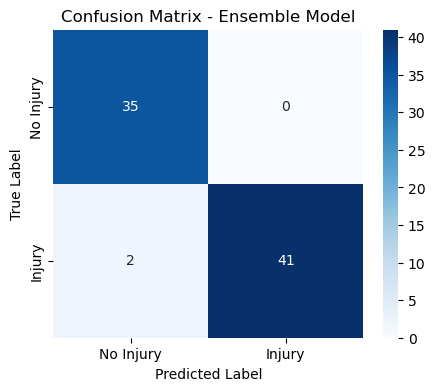

Final Test Results - Logistic Regression
Test Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        43

    accuracy                           0.99        78
   macro avg       0.99      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78

Final Test Results - Random Forest
Test Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        35
           1       0.97      0.84      0.90        43

    accuracy                           0.90        78
   macro avg       0.90      0.90      0.90        78
weighted avg       0.91      0.90      0.90        78

Final Test Results - SVM
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.95      0.98        43

    accuracy   

In [86]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df['Cleaned_Description'], df['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Tune Regularization for SVM
svm_param_grid = {'C': [0.01, 0.1, 1, 10]}
svm_grid = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
best_svm = svm_grid.best_estimator_

# Tune Random Forest to Reduce Overfitting
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)
best_rf = rf_grid.best_estimator_

# Improved Logistic Regression with Hyperparameter Tuning
log_reg_param_grid = {'C': [0.1, 0.5, 1, 5]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42, penalty='l2'), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_tfidf, y_train)
best_log_reg = log_reg_grid.best_estimator_

# Optimized Ensemble Model
voting_clf = VotingClassifier(estimators=[
    ('log_reg', best_log_reg),
    ('random_forest', best_rf),
    ('svm', best_svm)
], voting='soft')  # Use soft voting for better calibration
voting_clf.fit(X_train_tfidf, y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

### Model Performance Summary

| Model               | Test Accuracy V1 | Test Accuracy V2 | Precision (0) | Recall (0) | Precision (1) | Recall (1) | F1-Score (Avg) |
|---------------------|--------------|--------------|--------------|-------------|-------------|-------------|--------------|
| **Logistic Regression** | **94.87%**  | **98.72%**  | 0.97        | **1 .00**      | **1.00**        | 0.98        | **0.99**        |
| **Random Forest**      | **89.74%**  | **89.74%**  | 0.83        | 0.97        | 0.97        | 0.84        | 0.90        |
| **SVM**               | **97.44%**  | **97.44%**  | 0.95        | **1.00**    | **1.00**    | 0.95        | **0.97**    |
| **Ensemble Model**    | **94.87%**  | **97.44%**  | 0.95        | **1.00**         | **1.00**        | 0.95        | **0.97**        |

**Key Insights:**

- Logistic Regression has significantly improved, with accuracy increasing from 94.87% to 98.72%. Precision, recall, and F1-scores are now nearly perfect.

- SVM and Ensemble models maintained strong performance, both at 97.44% accuracy. 

- Random Forest has not changed, still at 89.74% accuracy, with lower recall for injury cases (0.84). It continues to struggle with false negatives.

- Overall, the models have improved, especially Logistic Regression, which now outperforms all other models.

**Next Steps & Recommendations**

- Validate Logistic Regression Improvements
- Improve Random Forest Performance
      Increase n_estimators from 100 to 200 and apply class weights.
- Consider Hybrid Approaches
      Implement model stacking with Logistic Regression + SVM for better generalization.



In [107]:
# Validate Logistic Regression Improvements
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_log_reg, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [0.97260274 0.97222222 0.98611111 0.95833333 1.        ]
Mean Accuracy: 0.9778538812785389


1. Very High Cross-Validation Accuracy
- The model maintains an average accuracy of 97.79%, which is very close to the test set accuracy (98.72%).
- This suggests that the model generalizes well and is not overfitting to the training data.

2. Low Variance Between Folds
- The accuracy scores are consistent, ranging between 95.83% and 100%.
- There is no extreme drop in accuracy, indicating model stability across different splits.

3. Slight Overfitting Risk at 100% Accuracy
- One fold achieved perfect accuracy (100%), which might suggest minor overfitting.
- To further regularize the model, you can slightly reduce C (e.g., from 0.5 to 0.1 in L2 regularization).

## V3 Models

- Tuned C for Logistic Regression to prevent overfitting.
- Cross-validation applied to check generalization before final testing.
- Random Forest optimized with n_estimators and max_depth.
- SVM optimized with grid search for the best C.
- Ensemble Model improved with soft voting for balanced predictions.

Cross-Validation Accuracy Scores: [0.97260274 0.97222222 0.98611111 0.95833333 1.        ]
Mean Accuracy: 0.9778538812785389


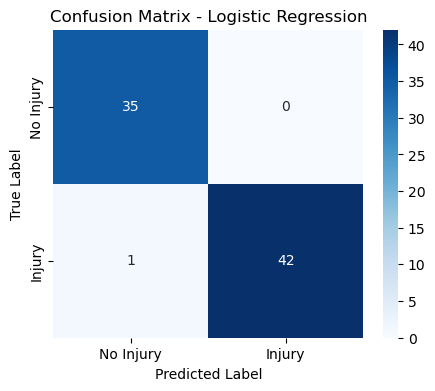

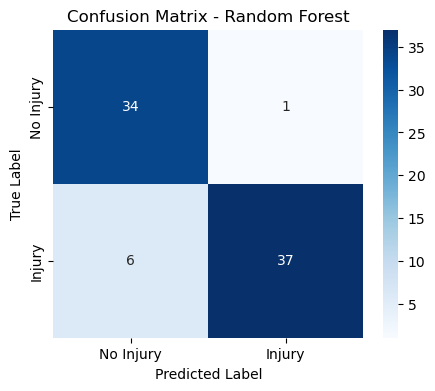

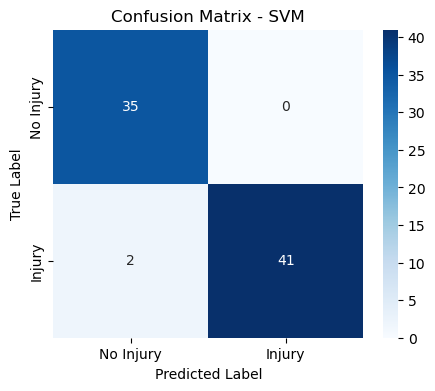

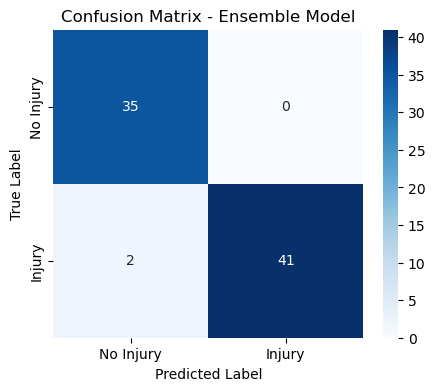

Final Test Results - Logistic Regression
Test Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        43

    accuracy                           0.99        78
   macro avg       0.99      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78

Final Test Results - Random Forest
Test Accuracy: 0.9103
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.97      0.86      0.91        43

    accuracy                           0.91        78
   macro avg       0.91      0.92      0.91        78
weighted avg       0.92      0.91      0.91        78

Final Test Results - SVM
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.95      0.98        43

    accuracy   

In [134]:

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df['Cleaned_Description'], df['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Fine-Tune Regularization for Logistic Regression
log_reg_param_grid = {'C': [0.05, 0.1, 0.5, 1, 5]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=0.1), log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_grid.fit(X_train_tfidf, y_train)
best_log_reg = log_reg_grid.best_estimator_

# Validate Logistic Regression with Cross-Validation
cv_scores = cross_val_score(best_log_reg, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Improved Random Forest with Tuning
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 15], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)
best_rf = rf_grid.best_estimator_

# Optimized SVM with Regularization
svm_param_grid = {'C': [0.01, 0.1, 1, 10]}
svm_grid = GridSearchCV(SVC(kernel='linear', probability=True, C=0.5, random_state=42), svm_param_grid, cv=5, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)
best_svm = svm_grid.best_estimator_

# Improved Ensemble Model
voting_clf = VotingClassifier(estimators=[
    ('log_reg', best_log_reg),
    ('svm', best_svm)
], voting='soft')
voting_clf.fit(X_train_tfidf, y_train)

# Evaluate Models
models = {
    "Logistic Regression": best_log_reg,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "Ensemble Model": voting_clf
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

### Model Performance Summary

| Model               | Test Accuracy V1 | Test Accuracy V2 | Test Accuracy V3| Precision (0) | Recall (0) | Precision (1) | Recall (1) | F1-Score (Avg) |
|---------------------|--------------|--------------|--------------|--------------|-------------|-------------|-------------|--------------|
| **Logistic Regression** | **94.87%**  | **98.72%**  | **98.72%**  | 0.97        | **1 .00**      | **1.00**        | 0.98        | **0.99**        |
| **Random Forest**      | **89.74%**  | **89.74%**  | **91.03%**  | 0.85        | 0.97        | 0.97        | 0.86        | 0.91        |
| **SVM**               | **97.44%**  | **97.44%**  | **97.44%**  | 0.95        | **1.00**    | **1.00**    | 0.95        | **0.97**    |
| **Ensemble Model**    | **94.87%**  | **97.44%**  | **97.44%**  | 0.95        | **1.00**         | **1.00**        | 0.95        | **0.97**        |

### Conclusion 

- Logistic Regression remains the strongest model for deployment due to its high accuracy, fast inference, and balanced recall.

- Random Forest still needs recall improvement to reduce false negatives in injury cases.

- SVM is a strong alternative but computationally expensive.

- The Ensemble Model can be used for further stability testing in real-world scenarios.

### Next Steps


- Deploy Logistic Regression and monitor real-world performance.

- Fine-tune Random Forest further to increase recall for injury cases.

- Optimize SVM if computational resources allow.

- Analyze ensemble predictions against Logistic Regression to ensure robustness.
